## Unlabelled data

In [76]:
import ruptures as rpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, Flatten, Reshape, Conv1D
from tensorflow.keras.models import Sequential

In [77]:
import data_processing
import feature_extraction

In [78]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

Extract the unllabelled data

In [79]:
unlabelled_df = data_processing.get_unlabelled(df)

In [80]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  
0   20090103012134.plt     0   135  
1   20090103012134.plt     0   135  
2   20090103012134.plt     0   135  
3   20090103012134.plt     0   135  
4   20090103012134.plt     0   135  
..                 ...   ...   ...  
28  20070723033153.plt     0   171  
29  20070723033153.plt     0   171  
30  20070723033153.plt     0   171  
31  20070723033153.plt     0   171  
32  20070723033153.plt     0   171  

[19449861 rows x 8 columns]

In [5]:
df['label'].value_counts()

label
0        19449861
walk      1585401
bus       1276632
bike       948061
train      847147
car        754825
Name: count, dtype: int64

In [4]:
df.groupby('label')['trajectory'].nunique()

label
0        17431
bike      1056
bus       1321
car       1082
train      629
walk      2299
Name: trajectory, dtype: int64

In [ ]:
df = data_processing.create_segments(df)

In [6]:
df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  segment  
0   20090103012134.plt     0   135        1  
1   20090103012134.plt     0   135        1  
2   20090103012134.plt     0   135        1  
3   20090103012134.plt     0   135        1  
4   20090103012134.plt     0   135        1  
..                 ...   ...   ...      ...  
28  20070723033153.plt     0   171    43099  
29  20070723033153.plt     0   171    43099  
30  20070723033153.plt     0   171    43099  
31  20070723033153.plt     0   171    43099  
32  20070723033153.plt     0   171    43099  

[24861927 rows x 9 columns]

In [9]:
df.groupby('label')['segment'].nunique()

label
0        22259
bike      1580
bus       1884
car       1348
train      793
walk      4103
Name: segment, dtype: int64

In [8]:
df.groupby('label')['segment'].nunique()

label
0        16496
bike      1558
bus       1867
car       1340
train      758
walk      4002
Name: segment, dtype: int64

In [9]:
df[df['trajectory'] == '20120727080700.plt']

lat         lon         alt  elapsed time                time  \
3    39.990067  116.442591  128.602005  41117.338368 2012-07-27 08:07:15   
4    39.990083  116.442321  133.234472  41117.338426 2012-07-27 08:07:20   
5    39.990083  116.441885  133.946749  41117.338484 2012-07-27 08:07:25   
6    39.990087  116.441528  133.204760  41117.338542 2012-07-27 08:07:30   
7    39.990087  116.441081  134.766332  41117.338600 2012-07-27 08:07:35   
..         ...         ...         ...           ...                 ...   
290  39.979481  116.303499  131.760207  41117.354861 2012-07-27 08:31:00   
292  39.979475  116.303497  131.097241  41117.354919 2012-07-27 08:31:05   
293  39.979374  116.303522  126.235679  41117.354977 2012-07-27 08:31:10   
294  39.979190  116.303587  119.301427  41117.355035 2012-07-27 08:31:15   
295  39.979081  116.303572  112.078146  41117.355093 2012-07-27 08:31:20   

             trajectory label  user  segment  distance     speed  time_diff  \
3    20120727080700.plt     0   163    22166  0.048132  0.009626        5.0   
4    20120727080700.plt     0   163    22166  0.022991  0.004598        5.0   
5    20120727080700.plt     0   163    22166  0.037216  0.007443        5.0   
6    20120727080700.plt     0   163    22166  0.030386  0.006077        5.0   
7    20120727080700.plt     0   163    22166  0.038046  0.007609        5.0   
..                  ...   ...   ...      ...       ...       ...        ...   
290  20120727080700.plt     0   163    22166  0.000507  0.000101        5.0   
292  20120727080700.plt     0   163    22166  0.000679  0.000340        2.0   
293  20120727080700.plt     0   163    22166  0.011389  0.002278        5.0   
294  20120727080700.plt     0   163    22166  0.021180  0.004236        5.0   
295  20120727080700.plt     0   163    22166  0.012222  0.002444        5.0   

     acceleration     bearing  heading_change     Vrate  angular_velocity  \
3       -0.000400  271.924069       33.275767  0.207741         -6.655153   
4       -0.001006  274.350421        2.426352  1.093513          0.485270   
5        0.000569  270.015719        4.334703  0.382224         -0.866941   
6       -0.000273  270.807797        0.792078  0.224787          0.158416   
7        0.000306  269.918761        0.889035  0.201354         -0.177807   
..            ...         ...             ...       ...               ...   
290     -0.000042  311.323586      225.945751  2.070380         45.189150   
292      0.000170  193.490543      193.490543  1.000000         96.745272   
293      0.000388  169.100564       24.389980  0.850869         -4.877996   
294      0.000392  164.975095        4.125468  0.462290         -0.825094   
295     -0.000358  185.763524       20.788429  0.732876          4.157686   

     angular_acceleration  
3               -4.859120  
4                1.428085  
5               -0.270442  
6                0.205071  
7               -0.067245  
..                    ...  
290             11.528095  
292            100.259900  
293            -20.324654  
294              0.810580  
295              0.996556  

[290 rows x 18 columns]

## Predicting the unlabelled datapoints

Function that gets the dataset with only the unlabelled datapoints:

In [6]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  
0   20090103012134.plt     0   135  
1   20090103012134.plt     0   135  
2   20090103012134.plt     0   135  
3   20090103012134.plt     0   135  
4   20090103012134.plt     0   135  
..                 ...   ...   ...  
28  20070723033153.plt     0   171  
29  20070723033153.plt     0   171  
30  20070723033153.plt     0   171  
31  20070723033153.plt     0   171  
32  20070723033153.plt     0   171  

[19449861 rows x 8 columns]

Segment unlabelled dataset as best as possible (only trajectories at first)

In [81]:
unlabelled_df = data_processing.create_segments(df)

In [82]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  segment  
0   20090103012134.plt     0   135        1  
1   20090103012134.plt     0   135        1  
2   20090103012134.plt     0   135        1  
3   20090103012134.plt     0   135        1  
4   20090103012134.plt     0   135        1  
..                 ...   ...   ...      ...  
28  20070723033153.plt     0   171    43099  
29  20070723033153.plt     0   171    43099  
30  20070723033153.plt     0   171    43099  
31  20070723033153.plt     0   171    43099  
32  20070723033153.plt     0   171    43099  

[24861927 rows x 9 columns]

Only the first 5 Million datapoints!

In [83]:
unlabelled_df = unlabelled_df.iloc[:5000000]

Do feature calculations on the unlabeled dataset

In [84]:
unlabelled_df = data_processing.calculations(unlabelled_df)

Check dataset

In [27]:
# Get the first 300 entries
first_300_unlabelled_df = unlabelled_df.head(10000)

# Save the filtered DataFrame to a CSV file
first_300_unlabelled_df.to_csv('first10000_unlabelled.csv', index=False)

Right now, every segment is the entire length of a trajectory

Thus, detect changepoints using Rutgers package

First: create a new index variable (to later match changepoints to dataset)

In [86]:
# Add an index column to the unlabelled DataFrame
unlabelled_df['index'] = range(1, len(unlabelled_df) + 1)

In [150]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
3     39.974320  116.399588  492.0  39816.056690 2009-01-03 01:21:38   
4     39.974365  116.399730  491.0  39816.056701 2009-01-03 01:21:39   
5     39.974391  116.399782  491.0  39816.056736 2009-01-03 01:21:42   
6     39.974426  116.399735  491.0  39816.056782 2009-01-03 01:21:46   
7     39.974458  116.399700  491.0  39816.056840 2009-01-03 01:21:51   
...         ...         ...    ...           ...                 ...   
1922  40.037868  116.210703  167.3  39592.390822 2008-05-24 09:22:47   
1923  40.037887  116.210702  167.3  39592.390845 2008-05-24 09:22:49   
1924  40.037905  116.210700  167.3  39592.390868 2008-05-24 09:22:51   
1925  40.037927  116.210695  167.3  39592.390891 2008-05-24 09:22:53   
1926  40.037945  116.210685  167.3  39592.390914 2008-05-24 09:22:55   

              trajectory label  user  segment  distance     speed  time_diff  \
3     20090103012134.plt     0   135        1  0.005672  0.002836        2.0   
4     20090103012134.plt     0   135        1  0.013094  0.013094        1.0   
5     20090103012134.plt     0   135        1  0.005291  0.001764        3.0   
6     20090103012134.plt     0   135        1  0.005584  0.001396        4.0   
7     20090103012134.plt     0   135        1  0.004643  0.000929        5.0   
...                  ...   ...   ...      ...       ...       ...        ...   
1922  20080524062407.plt     0   142    16493  0.002229  0.001114        2.0   
1923  20080524062407.plt     0   142    16493  0.002040  0.001020        2.0   
1924  20080524062407.plt     0   142    16493  0.002040  0.001020        2.0   
1925  20080524062407.plt     0   142    16493  0.002449  0.001224        2.0   
1926  20080524062407.plt     0   142    16493  0.002206  0.001103        2.0   

      acceleration     bearing  heading_change         Vrate  \
3    -1.669962e-03   77.547097      210.275581  1.177637e+00   
4     1.025781e-02   67.533389       10.013708  7.834018e-01   
5    -3.776780e-03   56.877188       10.656201  6.424578e+00   
6    -9.187014e-05  314.179106      257.301918  2.632170e-01   
7    -9.350913e-05  320.031126        5.852020  5.035132e-01   
...            ...         ...             ...           ...   
1922  9.166460e-05  356.276576        0.471867  1.645239e-01   
1923 -4.714886e-05  355.931797        0.344779  9.244841e-02   
1924 -7.272725e-13  355.931798        0.000001  1.426019e-09   
1925  1.021790e-04  350.191562        5.740236  1.669098e-01   
1926 -6.073696e-05  337.296990       12.894572  1.101417e-01   

      angular_velocity  angular_acceleration    index  
3        -1.051378e+02            -61.981946        1  
4        -1.001371e+01             95.124082        2  
5        -3.552067e+00              2.153880        3  
6         6.432548e+01             16.969387        4  
7         1.170404e+00            -12.631015        5  
...                ...                   ...      ...  
1922      2.359334e-01            -85.879438  9198001  
1923     -1.723893e-01             -0.204161  9198002  
1924      5.740384e-07              0.086195  9198003  
1925     -2.870118e+00             -1.435059  9198004  
1926     -6.447286e+00             -1.788584  9198005  

[9198005 rows x 19 columns]

The code crashes when trajectories are oo long. Thus, set a max length  (its like rolling window?)

ensures that no segment exceeds a given number of rows (max_length). If a segment is too long, it is split into multiple smaller segments.

In [87]:
def enforce_max_segment_length(df, max_length=200):
    """
    Splits segments in the DataFrame if they exceed `max_length` rows.
    
    Parameters:
    - df: DataFrame with a 'segment' column.
    - max_length: Maximum allowed length of each segment.
    
    Returns:
    - DataFrame with updated segment numbers.
    """
    new_df = df.copy()
    new_segments = []
    
    for segment_id in df['segment'].unique():
        segment_data = df[df['segment'] == segment_id]
        
        # If segment is too long, split it into multiple segments
        num_splits = int(len(segment_data) / max_length) + 1
        
        for i in range(num_splits):
            split_segment = segment_data.iloc[i * max_length : (i + 1) * max_length].copy()
            split_segment['segment'] = f"{segment_id}.{i}"  # Create unique sub-segment IDs
            new_segments.append(split_segment)
    
    return pd.concat(new_segments).reset_index(drop=True)

# **Apply the function to your dataset**
unlabelled_df = enforce_max_segment_length(unlabelled_df, max_length=200)

# **Check the updated segments**
print("Segments after enforcing max length:", unlabelled_df['segment'].unique())

Segments after enforcing max length: ['1.0' '1.1' '1.2' ... '6828.2' '6828.3' '6828.4']


In [13]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
0        39.974320  116.399588  492.0  39816.056690 2009-01-03 01:21:38   
1        39.974365  116.399730  491.0  39816.056701 2009-01-03 01:21:39   
2        39.974391  116.399782  491.0  39816.056736 2009-01-03 01:21:42   
3        39.974426  116.399735  491.0  39816.056782 2009-01-03 01:21:46   
4        39.974458  116.399700  491.0  39816.056840 2009-01-03 01:21:51   
...            ...         ...    ...           ...                 ...   
4816386  39.990915  116.309425  374.0  39911.504213 2009-04-08 12:06:04   
4816387  39.990637  116.309475  374.0  39911.504236 2009-04-08 12:06:06   
4816388  39.989247  116.309653  374.0  39911.504375 2009-04-08 12:06:18   
4816389  39.989022  116.309640  370.7  39911.504398 2009-04-08 12:06:20   
4816390  39.988950  116.309735  370.7  39911.504421 2009-04-08 12:06:22   

                 trajectory label  user segment  distance     speed  \
0        20090103012134.plt     0   135     1.0  0.005672  0.002836   
1        20090103012134.plt     0   135     1.0  0.013094  0.013094   
2        20090103012134.plt     0   135     1.0  0.005291  0.001764   
3        20090103012134.plt     0   135     1.0  0.005584  0.001396   
4        20090103012134.plt     0   135     1.0  0.004643  0.000929   
...                     ...   ...   ...     ...       ...       ...   
4816386  20090408111938.plt     0    25  6828.4  0.012593  0.006296   
4816387  20090408111938.plt     0    25  6828.4  0.031248  0.015624   
4816388  20090408111938.plt     0    25  6828.4  0.155306  0.012942   
4816389  20090408111938.plt     0    25  6828.4  0.025045  0.012522   
4816390  20090408111938.plt     0    25  6828.4  0.011355  0.005677   

         time_diff  acceleration     bearing  heading_change     Vrate  \
0              2.0     -0.001670   77.547097      210.275581  1.177637   
1              1.0      0.010258   67.533389       10.013708  0.783402   
2              3.0     -0.003777   56.877188       10.656201  6.424578   
3              4.0     -0.000092  314.179106      257.301918  0.263217   
4              5.0     -0.000094  320.031126        5.852020  0.503513   
...            ...           ...         ...             ...       ...   
4816386        2.0      0.000123  209.772875       17.888028  0.039004   
4816387        2.0      0.004664  172.165374       37.607501  0.597013   
4816388       12.0     -0.000223  174.383948        2.218574  0.207227   
4816389        2.0     -0.000210  182.593098        8.209149  0.033536   
4816390        2.0     -0.003422  134.599510       47.993588  1.205650   

         angular_velocity  angular_acceleration    index  
0             -105.137790            -61.981946        1  
1              -10.013708             95.124082        2  
2               -3.552067              2.153880        3  
3               64.325480             16.969387        4  
4                1.170404            -12.631015        5  
...                   ...                   ...      ...  
4816386         -8.944014              1.678510  4816387  
4816387        -18.803750             -4.929868  4816388  
4816388          0.184881              1.582386  4816389  
4816389          4.104575              1.959847  4816390  
4816390        -23.996794            -14.050684  4816391  

[4816391 rows x 19 columns]

In [88]:
unlabelled_df = data_processing.calculations(unlabelled_df)

In [89]:
import ruptures as rpt
import pandas as pd

def detect_change_points(group, segment_id, current_segment, total_segments, penalty=5):
    """
    Detects change points within a single segment using PELT with 'rbf',
    and prints progress during execution.

    Parameters:
    - group: DataFrame containing data for a single segment.
    - segment_id: The ID of the segment being processed.
    - current_segment: The current segment's position in the total.
    - total_segments: The total number of segments in the dataset.
    - penalty: Controls the sensitivity of segmentation.

    Returns:
    - List of detected change points (global indices).
    """
    print(f"Processing segment {segment_id} ({current_segment}/{total_segments}, {current_segment/total_segments*100:.2f}% done)")

    segment_data = group[['speed', 'acceleration']].values

    if len(segment_data) < 2:  # Skip small segments
        return []

    try:
        algo = rpt.Pelt(model="rbf").fit(segment_data)
        cps = algo.predict(pen=penalty)[:-1]  # Exclude last boundary

        # Convert change points from global index to `index_var`
        index_var_values = group.iloc[cps]['index'].tolist()
        return index_var_values  # Return `index_var` instead of raw index
    except Exception as e:
        print(f"Error processing segment {segment_id}: {e}")
        return []

# **Processing with Progress Tracking**
def process_segments_with_progress(df, penalty=5):
    """
    Processes each segment individually with progress tracking.

    Parameters:
    - df: DataFrame with ['segment', 'speed', 'acceleration']
    - penalty: Penalty for the change point detection.

    Returns:
    - Dictionary mapping segment numbers to detected change points.
    """
    change_points_dict = {}

    # Get unique segment IDs
    segment_ids = df['segment'].unique()
    total_segments = len(segment_ids)

    for i, segment_id in enumerate(segment_ids, start=1):
        group = df[df['segment'] == segment_id]
        change_points_dict[segment_id] = detect_change_points(group, segment_id, i, total_segments, penalty)

    return change_points_dict

# **Run the Change Point Detection with Progress Tracking**
change_points_dict = process_segments_with_progress(unlabelled_df, penalty=5)

print("Total processed segments:", len(change_points_dict))


Processing segment 1.0 (1/27175, 0.00% done)
Processing segment 1.1 (2/27175, 0.01% done)
Processing segment 1.10 (3/27175, 0.01% done)
Processing segment 1.11 (4/27175, 0.01% done)
Processing segment 1.2 (5/27175, 0.02% done)
Processing segment 1.3 (6/27175, 0.02% done)
Processing segment 1.4 (7/27175, 0.03% done)
Processing segment 1.5 (8/27175, 0.03% done)
Processing segment 1.6 (9/27175, 0.03% done)
Processing segment 1.7 (10/27175, 0.04% done)
Processing segment 1.8 (11/27175, 0.04% done)
Processing segment 1.9 (12/27175, 0.04% done)
Processing segment 10.0 (13/27175, 0.05% done)
Processing segment 10.1 (14/27175, 0.05% done)
Processing segment 10.2 (15/27175, 0.06% done)
Processing segment 10.3 (16/27175, 0.06% done)
Processing segment 10.4 (17/27175, 0.06% done)
Processing segment 10.5 (18/27175, 0.07% done)
Processing segment 10.6 (19/27175, 0.07% done)
Processing segment 10.7 (20/27175, 0.07% done)
Processing segment 100.0 (21/27175, 0.08% done)
Processing segment 1000.0 (22/2

In [90]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
3       39.974426  116.399735  491.0  39816.056782 2009-01-03 01:21:46   
4       39.974458  116.399700  491.0  39816.056840 2009-01-03 01:21:51   
5       39.974491  116.399732  490.0  39816.056898 2009-01-03 01:21:56   
6       39.974530  116.399758  489.0  39816.056956 2009-01-03 01:22:01   
7       39.974577  116.399745  490.0  39816.056991 2009-01-03 01:22:04   
...           ...         ...    ...           ...                 ...   
512806  39.975701  116.331272  150.0  39833.222049 2009-01-20 05:19:45   
512807  39.975699  116.331199  154.0  39833.222106 2009-01-20 05:19:50   
512808  39.975677  116.331150  159.0  39833.222164 2009-01-20 05:19:55   
512809  39.975643  116.331099  164.0  39833.222222 2009-01-20 05:20:00   
512810  39.975619  116.331019  169.0  39833.222280 2009-01-20 05:20:05   

                trajectory label  user segment  distance     speed  time_diff  \
3       20090103012134.plt     0   135     1.0  0.005584  0.001396        4.0   
4       20090103012134.plt     0   135     1.0  0.004643  0.000929        5.0   
5       20090103012134.plt     0   135     1.0  0.004572  0.000914        5.0   
6       20090103012134.plt     0   135     1.0  0.004870  0.000974        5.0   
7       20090103012134.plt     0   135     1.0  0.005342  0.001781        3.0   
...                    ...   ...   ...     ...       ...       ...        ...   
512806  20090120010934.plt     0   158   999.0  0.006256  0.001251        5.0   
512807  20090120010934.plt     0   158   999.0  0.006224  0.001245        5.0   
512808  20090120010934.plt     0   158   999.0  0.004839  0.000968        5.0   
512809  20090120010934.plt     0   158   999.0  0.005760  0.001152        5.0   
512810  20090120010934.plt     0   158   999.0  0.007321  0.001464        5.0   

        acceleration     bearing  heading_change     Vrate  angular_velocity  \
3          -0.000092  314.179106      257.301918  0.263217         64.325480   
4          -0.000094  320.031126        5.852020  0.503513          1.170404   
5          -0.000003   36.616347      283.414779  0.015568        -56.682956   
6           0.000012   27.061885        9.554462  0.061215         -1.910892   
7           0.000269  348.032515      320.970630  0.453068        106.990210   
...              ...         ...             ...       ...               ...   
512806     -0.000098  276.121913        1.732387  0.393379          0.346477   
512807     -0.000001  267.952465        8.169448  0.005093         -1.633890   
512808     -0.000055  239.634291       28.318174  0.286241         -5.663635   
512809      0.000037  228.978003       10.656288  0.159878         -2.131258   
512810      0.000062  248.620552       19.642549  0.213168          3.928510   

        angular_acceleration   index  
3                  16.969387       4  
4                 -12.631015       5  
5                 -11.570672       6  
6                  10.954413       7  
7                  36.300368       8  
...                      ...     ...  
512806             -0.993700  512807  
512807             -0.396073  512808  
512808             -0.805949  512809  
512809              0.706475  512810  
512810              1.211953  512811  

[4734516 rows x 19 columns]

In [91]:
change_points_dict

{'1.0': [54],
 '1.1': [349],
 '1.10': [2089, 2114],
 '1.11': [],
 '1.2': [574],
 '1.3': [704],
 '1.4': [],
 '1.5': [],
 '1.6': [1339],
 '1.7': [1489],
 '1.8': [1664],
 '1.9': [],
 '10.0': [8100, 8145],
 '10.1': [8210, 8235, 8285, 8295],
 '10.2': [8420, 8455, 8520, 8555],
 '10.3': [8640, 8710, 8725],
 '10.4': [8800, 8835, 8915, 8940],
 '10.5': [9005, 9065, 9085, 9130],
 '10.6': [9225, 9245, 9265, 9335],
 '10.7': [9380, 9395, 9460],
 '100.0': [113180],
 '1000.0': [],
 '1001.0': [512923, 512948, 512958, 513018],
 '1001.1': [513148, 513193],
 '1002.0': [513265, 513310, 513330, 513375],
 '1002.1': [],
 '1003.0': [],
 '1004.0': [],
 '1005.0': [513647, 513727, 513777],
 '1005.1': [513877, 513942],
 '1005.2': [514082],
 '1005.3': [514242],
 '1005.4': [514482],
 '1005.5': [514617, 514672, 514702, 514737],
 '1005.6': [514807, 514902],
 '1005.7': [515047, 515157],
 '1005.8': [],
 '1006.0': [],
 '1007.0': [515390],
 '1008.0': [],
 '1009.0': [],
 '101.0': [113213, 113248, 113278],
 '1010.0': [51561

Extract the segments

In [92]:
# Flatten all change points into a single list
change_points = [cp for cps in change_points_dict.values() for cp in cps]

# Display result
print(change_points)


[54, 349, 2089, 2114, 574, 704, 1339, 1489, 1664, 8100, 8145, 8210, 8235, 8285, 8295, 8420, 8455, 8520, 8555, 8640, 8710, 8725, 8800, 8835, 8915, 8940, 9005, 9065, 9085, 9130, 9225, 9245, 9265, 9335, 9380, 9395, 9460, 113180, 512923, 512948, 512958, 513018, 513148, 513193, 513265, 513310, 513330, 513375, 513647, 513727, 513777, 513877, 513942, 514082, 514242, 514482, 514617, 514672, 514702, 514737, 514807, 514902, 515047, 515157, 515390, 113213, 113248, 113278, 515615, 515769, 515904, 515939, 516269, 516409, 516574, 516689, 516719, 516824, 517053, 517098, 517263, 517388, 517468, 517483, 517528, 517553, 517662, 517707, 517742, 517907, 517957, 517972, 518016, 518071, 518096, 518116, 518241, 518266, 518291, 518331, 518361, 518381, 518426, 518461, 518471, 518526, 518541, 518621, 518661, 518676, 518721, 518736, 518865, 519325, 519553, 519593, 519608, 519653, 519733, 519808, 519828, 519853, 519953, 519978, 519998, 520118, 520465, 520475, 520953, 521073, 521288, 521848, 521969, 521989, 522382

In [93]:
import numpy as np

def assign_new_segments(df, change_points_df):
    """
    Assigns new segment numbers based on segment changes and detected change points.

    Parameters:
    - df: DataFrame with ['segment', 'index']
    - change_points_df: DataFrame or list containing detected change points.

    Returns:
    - df: DataFrame with a new 'new_segment' column.
    """
    df = df.sort_values(by=['segment', 'index']).copy()  # Ensure correct ordering
    df['new_segment'] = 0  # Initialize new segment column

    change_points_set = set(change_points_df['change_point']) if isinstance(change_points_df, pd.DataFrame) else set(change_points_df)

    new_segment = 1  # Start segment numbering
    df.iloc[0, df.columns.get_loc('new_segment')] = new_segment  # First row starts at segment 1

    # Efficiently assign segment numbers using NumPy
    segment_change = df['segment'] != df['segment'].shift(1)  # Detect where 'segment' changes
    index_change = df['index'].isin(change_points_set)  # Detect where 'index' is in change points

    # Combine conditions: new segment when 'segment' changes OR 'index' is in change points
    new_segment_mask = segment_change | index_change

    # Assign new segment numbers cumulatively
    df.loc[new_segment_mask, 'new_segment'] = np.arange(1, new_segment_mask.sum() + 1)

    # Forward fill to assign the same segment number until the next change
    df['new_segment'] = df['new_segment'].replace(0, np.nan).ffill().astype(int)

    return df

# **Apply the function**
updated_df = assign_new_segments(unlabelled_df, change_points)

# **Check the result**
print(updated_df[['segment', 'new_segment', 'index']].head(50))


   segment  new_segment  index
3      1.0            1      4
4      1.0            1      5
5      1.0            1      6
6      1.0            1      7
7      1.0            1      8
8      1.0            1      9
9      1.0            1     10
10     1.0            1     11
11     1.0            1     12
12     1.0            1     13
13     1.0            1     14
14     1.0            1     15
15     1.0            1     16
16     1.0            1     17
17     1.0            1     18
18     1.0            1     19
19     1.0            1     20
20     1.0            1     21
21     1.0            1     22
22     1.0            1     23
23     1.0            1     24
24     1.0            1     25
25     1.0            1     26
26     1.0            1     27
27     1.0            1     28
28     1.0            1     29
29     1.0            1     30
30     1.0            1     31
31     1.0            1     32
32     1.0            1     33
33     1.0            1     34
34     1

In [94]:
updated_df

lat         lon    alt  elapsed time                time  \
3       39.974426  116.399735  491.0  39816.056782 2009-01-03 01:21:46   
4       39.974458  116.399700  491.0  39816.056840 2009-01-03 01:21:51   
5       39.974491  116.399732  490.0  39816.056898 2009-01-03 01:21:56   
6       39.974530  116.399758  489.0  39816.056956 2009-01-03 01:22:01   
7       39.974577  116.399745  490.0  39816.056991 2009-01-03 01:22:04   
...           ...         ...    ...           ...                 ...   
512806  39.975701  116.331272  150.0  39833.222049 2009-01-20 05:19:45   
512807  39.975699  116.331199  154.0  39833.222106 2009-01-20 05:19:50   
512808  39.975677  116.331150  159.0  39833.222164 2009-01-20 05:19:55   
512809  39.975643  116.331099  164.0  39833.222222 2009-01-20 05:20:00   
512810  39.975619  116.331019  169.0  39833.222280 2009-01-20 05:20:05   

                trajectory label  user segment  distance     speed  time_diff  \
3       20090103012134.plt     0   135     1.0  0.005584  0.001396        4.0   
4       20090103012134.plt     0   135     1.0  0.004643  0.000929        5.0   
5       20090103012134.plt     0   135     1.0  0.004572  0.000914        5.0   
6       20090103012134.plt     0   135     1.0  0.004870  0.000974        5.0   
7       20090103012134.plt     0   135     1.0  0.005342  0.001781        3.0   
...                    ...   ...   ...     ...       ...       ...        ...   
512806  20090120010934.plt     0   158   999.0  0.006256  0.001251        5.0   
512807  20090120010934.plt     0   158   999.0  0.006224  0.001245        5.0   
512808  20090120010934.plt     0   158   999.0  0.004839  0.000968        5.0   
512809  20090120010934.plt     0   158   999.0  0.005760  0.001152        5.0   
512810  20090120010934.plt     0   158   999.0  0.007321  0.001464        5.0   

        acceleration     bearing  heading_change     Vrate  angular_velocity  \
3          -0.000092  314.179106      257.301918  0.263217         64.325480   
4          -0.000094  320.031126        5.852020  0.503513          1.170404   
5          -0.000003   36.616347      283.414779  0.015568        -56.682956   
6           0.000012   27.061885        9.554462  0.061215         -1.910892   
7           0.000269  348.032515      320.970630  0.453068        106.990210   
...              ...         ...             ...       ...               ...   
512806     -0.000098  276.121913        1.732387  0.393379          0.346477   
512807     -0.000001  267.952465        8.169448  0.005093         -1.633890   
512808     -0.000055  239.634291       28.318174  0.286241         -5.663635   
512809      0.000037  228.978003       10.656288  0.159878         -2.131258   
512810      0.000062  248.620552       19.642549  0.213168          3.928510   

        angular_acceleration   index  new_segment  
3                  16.969387       4            1  
4                 -12.631015       5            1  
5                 -11.570672       6            1  
6                  10.954413       7            1  
7                  36.300368       8            1  
...                      ...     ...          ...  
512806             -0.993700  512807        99100  
512807             -0.396073  512808        99100  
512808             -0.805949  512809        99100  
512809              0.706475  512810        99100  
512810              1.211953  512811        99100  

[4734516 rows x 20 columns]

Save the dataset for future use!

In [ ]:
# Select the first 5000 rows
testdata = updated_df.iloc[:5000]
testdata
testdata.to_csv('testdata.csv', index=False)

In [96]:
# Read in the dataset 'testdata' but only the first 100 rows
testdf = pd.read_csv('testdata.csv', skiprows=range(1, 600), nrows=200)

# Display the first few rows to verify
testdf.head()

lat         lon    alt  elapsed time                 time  \
0  39.968720  116.395848  127.0  39816.092731  2009-01-03 02:13:32   
1  39.968724  116.395920  122.0  39816.092789  2009-01-03 02:13:37   
2  39.968695  116.395977  114.0  39816.092836  2009-01-03 02:13:41   
3  39.968680  116.396046  104.0  39816.092894  2009-01-03 02:13:46   
4  39.968674  116.396108  105.0  39816.092951  2009-01-03 02:13:51   

           trajectory  label  user segment  distance     speed  time_diff  \
0  20090103012134.plt      0   135   1.0.3  0.005088  0.001272        4.0   
1  20090103012134.plt      0   135   1.0.3  0.006152  0.001230        5.0   
2  20090103012134.plt      0   135   1.0.3  0.005830  0.001458        4.0   
3  20090103012134.plt      0   135   1.0.3  0.006112  0.001222        5.0   
4  20090103012134.plt      0   135   1.0.3  0.005326  0.001065        5.0   

   acceleration     bearing  heading_change     Vrate  angular_velocity  \
0      0.000024   98.799968        7.716640  0.075255          1.929160   
1     -0.000008   85.853890       12.946078  0.033794         -2.589216   
2      0.000057  123.578196       37.724306  0.155890          9.431076   
3     -0.000047  105.836186       17.742010  0.192388         -3.548402   
4     -0.000031   97.196735        8.639452  0.147695         -1.727890   

   angular_acceleration  index  new_segment  
0              1.017735    612            7  
1             -0.903675    613            7  
2              3.005073    614            7  
3             -2.595896    615            7  
4              0.364102    616            7

Plot over time!

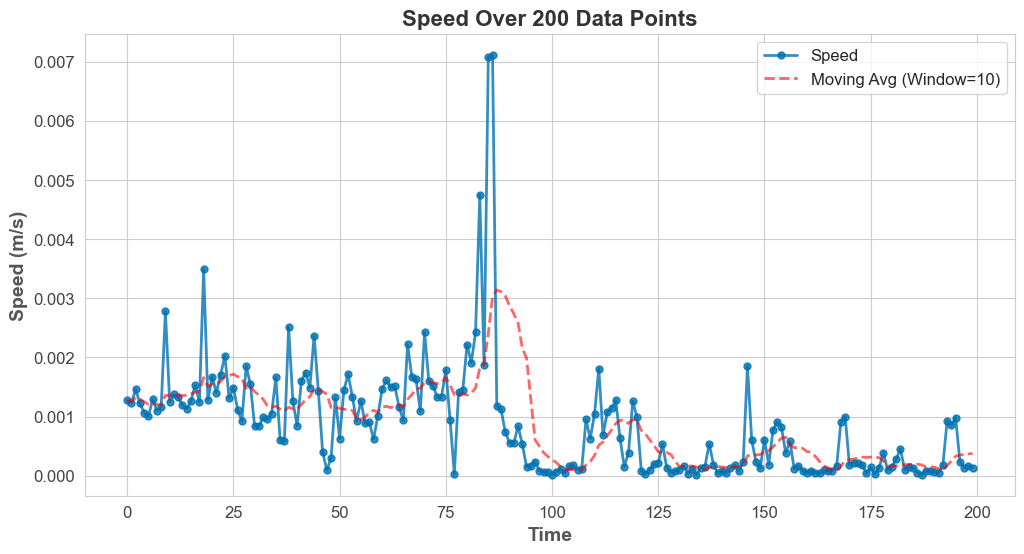

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the figure and plot
plt.figure(figsize=(12, 6))
plt.plot(testdf['speed'], marker='o', linestyle='-', color='#0072B2', markersize=5, linewidth=2, alpha=0.8, label="Speed")

# Add title and labels with enhanced formatting
plt.title('Speed Over 200 Data Points', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Time', fontsize=14, fontweight='bold', color='#555555')
plt.ylabel('Speed (m/s)', fontsize=14, fontweight='bold', color='#555555')

# Improve tick formatting
plt.xticks(fontsize=12, color='#444444')
plt.yticks(fontsize=12, color='#444444')

# Add a smooth trend line using a moving average
window_size = 10  # Adjust for smoothing level
testdf['speed_smooth'] = testdf['speed'].rolling(window=window_size, min_periods=1).mean()
plt.plot(testdf['speed_smooth'], color='red', linewidth=2, linestyle='--', alpha=0.6, label='Moving Avg (Window=10)')

# Add legend
plt.legend(fontsize=12, loc='upper right')

# Save the plot as an image file
plt.savefig('Graphs/speed_over_time.png', dpi=400)
# Show the improved plot
plt.show()



Do calculations again on new segment!

In [98]:
updated_df = data_processing.calculations(updated_df, segment ='new_segment')

In [43]:
updated_df

lat         lon    alt  elapsed time                time  \
6       39.974530  116.399758  489.0  39816.056956 2009-01-03 01:22:01   
7       39.974577  116.399745  490.0  39816.056991 2009-01-03 01:22:04   
8       39.974623  116.399731  491.0  39816.057025 2009-01-03 01:22:07   
9       39.974666  116.399713  491.0  39816.057060 2009-01-03 01:22:10   
10      39.974700  116.399755  491.0  39816.057095 2009-01-03 01:22:13   
...           ...         ...    ...           ...                 ...   
512806  39.975701  116.331272  150.0  39833.222049 2009-01-20 05:19:45   
512807  39.975699  116.331199  154.0  39833.222106 2009-01-20 05:19:50   
512808  39.975677  116.331150  159.0  39833.222164 2009-01-20 05:19:55   
512809  39.975643  116.331099  164.0  39833.222222 2009-01-20 05:20:00   
512810  39.975619  116.331019  169.0  39833.222280 2009-01-20 05:20:05   

                trajectory label  user  segment  distance     speed  \
6       20090103012134.plt     0   135    1.0.0  0.004870  0.000974   
7       20090103012134.plt     0   135    1.0.0  0.005342  0.001781   
8       20090103012134.plt     0   135    1.0.0  0.005252  0.001751   
9       20090103012134.plt     0   135    1.0.0  0.005021  0.001674   
10      20090103012134.plt     0   135    1.0.0  0.005206  0.001735   
...                    ...   ...   ...      ...       ...       ...   
512806  20090120010934.plt     0   158  999.0.0  0.006256  0.001251   
512807  20090120010934.plt     0   158  999.0.0  0.006224  0.001245   
512808  20090120010934.plt     0   158  999.0.0  0.004839  0.000968   
512809  20090120010934.plt     0   158  999.0.0  0.005760  0.001152   
512810  20090120010934.plt     0   158  999.0.0  0.007321  0.001464   

        time_diff  acceleration     bearing  heading_change     Vrate  \
6             5.0      0.000012   27.061885        9.554462  0.061215   
7             3.0      0.000269  348.032515      320.970630  0.453068   
8             3.0     -0.000010  346.871561        1.160954  0.017141   
9             3.0     -0.000026  342.214346        4.657215  0.045977   
10            3.0      0.000021   43.429855      298.784491  0.035450   
...           ...           ...         ...             ...       ...   
512806        5.0     -0.000098  276.121913        1.732387  0.393379   
512807        5.0     -0.000001  267.952465        8.169448  0.005093   
512808        5.0     -0.000055  239.634291       28.318174  0.286241   
512809        5.0      0.000037  228.978003       10.656288  0.159878   
512810        5.0      0.000062  248.620552       19.642549  0.213168   

        angular_velocity  angular_acceleration   index  new_segment  
6              -1.910892             10.954413       7            1  
7             106.990210             36.300368       8            1  
8              -0.386985            -35.792398       9            1  
9              -1.552405             -0.388473      10            1  
10            -99.594830            -32.680808      11            1  
...                  ...                   ...     ...          ...  
512806          0.346477             -0.993700  512807        99100  
512807         -1.633890             -0.396073  512808        99100  
512808         -5.663635             -0.805949  512809        99100  
512809         -2.131258              0.706475  512810        99100  
512810          3.928510              1.211953  512811        99100  

[4437343 rows x 20 columns]

Save the unlabelled dataset

In [45]:
updated_df.to_pickle("updated_df.pkl")

Finished

## Predict labels und unlabelled dataset

# Predict the unlabelled data

first train xgboost

In [102]:
df = data_processing.read_all_users('geolife_trajectories')

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [103]:
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

In [104]:
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
feature_df = df.groupby('segment').apply(feature_extraction.extract_features).reset_index(drop=True)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_60382/3713734458.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = df.groupby('segment').apply(feature_extraction.extract_features).reset_index(drop=True)


In [105]:
feature_df

label  segment          trajectory  start_time  trajectory_length  \
0      bus        1  20080328075913.plt           8                130   
1      bus        2  20080101093115.plt           9                183   
2     walk        4  20070417130153.plt          13                 32   
3     walk        5  20070416130252.plt          13                  3   
4      bus        6  20070416130252.plt          13                 21   
...    ...      ...                 ...         ...                ...   
9839  bike    10069  20080920033106.plt          14                 99   
9840  bike    10071  20080509081231.plt          10                 79   
9841   car    10072  20071019052429.plt           5                 22   
9842  walk    10073  20071019052429.plt           6                 27   
9843  walk    10074  20110306101335.plt          11                  4   

      total_distance  expected_speed  max_speed  mean_speed  top_1_speed  ...  \
0           5.201532        0.005817   0.021213    5.257022     0.021213  ...   
1           9.573456        0.012569   0.019212   37.058540     0.019212  ...   
2           5.738752        0.001481   0.004007   11.314079     0.004007  ...   
3           0.069486        0.001727   0.002175   10.876102     0.002175  ...   
4           4.958004        0.006256   0.012803   24.416981     0.012803  ...   
...              ...             ...        ...         ...          ...  ...   
9839        1.613206        0.003262   0.006629   11.852124     0.006629  ...   
9840        3.611016        0.003444   0.015397   10.061654     0.015397  ...   
9841       14.017147        0.010012   0.017691   32.141230     0.017691  ...   
9842        1.779871        0.000598   0.001429    1.768572     0.001429  ...   
9843        0.006030        0.000301   0.000538    1.447173     0.000538  ...   

      duration  average_acceleration  speed_std  acceleration_std  \
0     0.989444         -3.701620e-05   0.004957          0.000740   
1     0.258333         -1.627979e-05   0.004727          0.000426   
2     0.507222         -5.142116e-06   0.000643          0.000061   
3     0.006389          7.647611e-06   0.000392          0.000060   
4     0.203056         -7.344651e-05   0.003469          0.000338   
...        ...                   ...        ...               ...   
9839  0.136111          1.659785e-06   0.001272          0.000221   
9840  0.358889          5.201067e-05   0.002169          0.000747   
9841  0.436111         -1.551572e-05   0.004853          0.000167   
9842  1.006389          6.019019e-07   0.000337          0.000003   
9843  0.004167         -3.494153e-06   0.000159          0.000046   

      bearing_changes       HCR  stops        SR  VC       VCR  
0                  48  0.369231     10  0.076923  66  0.507692  
1                  12  0.065574      0  0.000000  18  0.098361  
2                   8  0.250000      1  0.031250  11  0.343750  
3                   3  1.000000      0  0.000000   2  0.666667  
4                   2  0.095238      1  0.047619  15  0.714286  
...               ...       ...    ...       ...  ..       ...  
9839               48  0.484848      2  0.020202  33  0.333333  
9840               33  0.417722      1  0.012658  45  0.569620  
9841               11  0.500000      0  0.000000  13  0.590909  
9842               15  0.555556      3  0.111111  15  0.555556  
9843                1  0.250000      3  0.750000   2  0.500000  

[9844 rows x 25 columns]

Train the model using labelled data

In [106]:
encoder = LabelEncoder()
feature_df['label'] = encoder.fit_transform(feature_df['label'])  # Encodes labels into numbers

In [148]:
feature_df

label  segment          trajectory  start_time  trajectory_length  \
0         1        1  20080328075913.plt           8                130   
1         1        2  20080101093115.plt           9                183   
2         4        4  20070417130153.plt          13                 32   
3         4        5  20070416130252.plt          13                  3   
4         1        6  20070416130252.plt          13                 21   
...     ...      ...                 ...         ...                ...   
9839      0    10069  20080920033106.plt          14                 99   
9840      0    10071  20080509081231.plt          10                 79   
9841      2    10072  20071019052429.plt           5                 22   
9842      4    10073  20071019052429.plt           6                 27   
9843      4    10074  20110306101335.plt          11                  4   

      total_distance  expected_speed  max_speed  mean_speed  top_1_speed  ...  \
0           5.201532        0.005817   0.021213    5.257022     0.021213  ...   
1           9.573456        0.012569   0.019212   37.058540     0.019212  ...   
2           5.738752        0.001481   0.004007   11.314079     0.004007  ...   
3           0.069486        0.001727   0.002175   10.876102     0.002175  ...   
4           4.958004        0.006256   0.012803   24.416981     0.012803  ...   
...              ...             ...        ...         ...          ...  ...   
9839        1.613206        0.003262   0.006629   11.852124     0.006629  ...   
9840        3.611016        0.003444   0.015397   10.061654     0.015397  ...   
9841       14.017147        0.010012   0.017691   32.141230     0.017691  ...   
9842        1.779871        0.000598   0.001429    1.768572     0.001429  ...   
9843        0.006030        0.000301   0.000538    1.447173     0.000538  ...   

      duration  average_acceleration  speed_std  acceleration_std  \
0     0.989444         -3.701620e-05   0.004957          0.000740   
1     0.258333         -1.627979e-05   0.004727          0.000426   
2     0.507222         -5.142116e-06   0.000643          0.000061   
3     0.006389          7.647611e-06   0.000392          0.000060   
4     0.203056         -7.344651e-05   0.003469          0.000338   
...        ...                   ...        ...               ...   
9839  0.136111          1.659785e-06   0.001272          0.000221   
9840  0.358889          5.201067e-05   0.002169          0.000747   
9841  0.436111         -1.551572e-05   0.004853          0.000167   
9842  1.006389          6.019019e-07   0.000337          0.000003   
9843  0.004167         -3.494153e-06   0.000159          0.000046   

      bearing_changes       HCR  stops        SR  VC       VCR  
0                  48  0.369231     10  0.076923  66  0.507692  
1                  12  0.065574      0  0.000000  18  0.098361  
2                   8  0.250000      1  0.031250  11  0.343750  
3                   3  1.000000      0  0.000000   2  0.666667  
4                   2  0.095238      1  0.047619  15  0.714286  
...               ...       ...    ...       ...  ..       ...  
9839               48  0.484848      2  0.020202  33  0.333333  
9840               33  0.417722      1  0.012658  45  0.569620  
9841               11  0.500000      0  0.000000  13  0.590909  
9842               15  0.555556      3  0.111111  15  0.555556  
9843                1  0.250000      3  0.750000   2  0.500000  

[9844 rows x 25 columns]

In [149]:
# Define features and target, drop trajectory column
X = feature_df.drop(columns=['label', 'trajectory', 'start_time', 'total_distance', 'segment','trajectory_length', 'duration','stops','VC'])  # Replace 'label' with actual target column name
y = feature_df['label']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

In [151]:
y_test

5562    4
3572    0
2988    1
4502    0
3246    4
       ..
3299    1
2074    4
8554    1
4382    1
5670    4
Name: label, Length: 1969, dtype: int64

In [110]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(set(y_train)),  
    eval_metric="mlogloss",  
    use_label_encoder=False,
    random_state=42,
    colsample_bytree= 0.8, 
    learning_rate= 0.2,
    max_depth= 4,
    min_child_weight= 1,
    n_estimators= 300, 
    subsample= 0.8
)

In [111]:
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)


# Decode labels back to original transport mode names
y_test = encoder.inverse_transform(y_test)
y_pred = encoder.inverse_transform(y_pred)

# Evaluate model
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Accuracy: 0.8450990350431691
Classification Report:
               precision    recall  f1-score   support

        bike       0.91      0.83      0.87       305
         bus       0.75      0.77      0.76       382
         car       0.80      0.74      0.77       279
       train       0.82      0.71      0.76       157
        walk       0.88      0.95      0.91       846

    accuracy                           0.85      1969
   macro avg       0.83      0.80      0.81      1969
weighted avg       0.84      0.85      0.84      1969

Confusion Matrix:
 [[252  11   2   1  39]
 [  6 293  34   6  43]
 [  4  51 207  11   6]
 [  0  12  14 111  20]
 [ 14  22   3   6 801]]


# Now PREDICT the unlabelled data

Create features on the unlabelled dataset

In [112]:
unlabelled_feature_df = updated_df.groupby('new_segment').apply(feature_extraction.extract_features).reset_index(drop=True)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_60382/1487996005.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unlabelled_feature_df = updated_df.groupby('new_segment').apply(feature_extraction.extract_features).reset_index(drop=True)


In [113]:
unlabelled_feature_df

label segment          trajectory  start_time  trajectory_length  \
0         0     1.0  20090103012134.plt           1                 47   
1         0     1.0  20090103012134.plt           1                144   
2         0     1.1  20090103012134.plt           1                142   
3         0     1.1  20090103012134.plt           1                 49   
4         0    1.10  20090103012134.plt           5                 82   
...     ...     ...                 ...         ...                ...   
98970     0   996.0  20090127062524.plt          12                 14   
98971     0   996.1  20090127062524.plt          12                156   
98972     0   997.0  20090120010934.plt           1                 46   
98973     0   998.0  20090120010934.plt           4                 91   
98974     0   999.0  20090120010934.plt           5                101   

       total_distance  expected_speed  max_speed  mean_speed  top_1_speed  \
0            0.389955        0.003174   0.023952    9.956297     0.023952   
1            0.829703        0.001786   0.007453    5.950061     0.007453   
2            0.821745        0.001797   0.007795    5.928420     0.007795   
3            0.261089        0.001326   0.001827    4.771176     0.001827   
4            0.287999        0.001286   0.005923    3.094915     0.005923   
...               ...             ...        ...         ...          ...   
98970        0.278039        0.003972   0.004770   15.399110     0.004770   
98971        2.691775        0.003451   0.008016   12.503727     0.008016   
98972        0.871286        0.003788   0.022307   13.940570     0.022307   
98973        0.568748        0.001224   0.004738    4.499983     0.004738   
98974        0.650485        0.001288   0.003838    4.683492     0.003838   

       ...  duration  average_acceleration  speed_std  acceleration_std  \
0      ...  0.039167         -2.551455e-05   0.003861          0.003046   
1      ...  0.139444          3.487400e-05   0.000888          0.000409   
2      ...  0.138611          5.126215e-05   0.000938          0.000564   
3      ...  0.054722          2.879364e-06   0.000256          0.000095   
4      ...  0.093056          1.508982e-04   0.001479          0.000930   
...    ...       ...                   ...        ...               ...   
98970  ...  0.018056          1.961006e-05   0.000537          0.000176   
98971  ...  0.215278         -5.197381e-06   0.001063          0.000252   
98972  ...  0.062500         -3.480469e-06   0.004505          0.001104   
98973  ...  0.126389         -6.227851e-07   0.000711          0.000160   
98974  ...  0.138889          2.260051e-06   0.000543          0.000129   

       bearing_changes       HCR  stops        SR  VC       VCR  
0                   20  0.425532      2  0.042553  29  0.617021  
1                   16  0.111111      0  0.000000  30  0.208333  
2                   26  0.183099      0  0.000000  31  0.218310  
3                   10  0.204082      0  0.000000  10  0.204082  
4                   43  0.524390     25  0.304878  63  0.768293  
...                ...       ...    ...       ...  ..       ...  
98970                6  0.428571      0  0.000000   3  0.214286  
98971               57  0.365385      1  0.006410  53  0.339744  
98972               30  0.652174      1  0.021739  35  0.760870  
98973               39  0.428571      0  0.000000  41  0.450549  
98974               49  0.485149      0  0.000000  37  0.366337  

[98975 rows x 25 columns]

Change feature extraction function! Because there are some different columns in the newly created unlabeled datset

In [118]:
def extract_features(group):
    features = {}
    
    features['label'] = group['label'].iloc[0]
    features['segment'] = group['segment'].iloc[0]
    features['new_segment'] = group['new_segment'].iloc[0]
    # Trajectory-level information
    features['trajectory'] = group['trajectory'].iloc[0]
    features['start_time'] = group['time'].iloc[0].hour  # Extract the hour of the day
    features['trajectory_length'] = len(group)  # Total number of points
    
    # Distance-based features
    features['total_distance'] = group['distance'].sum()
    features['average_speed'] = group['speed'].mean()
    features['max_speed'] = group['speed'].max()
    
    # Time-based features
    duration = (group['time'].iloc[-1] - group['time'].iloc[0]).total_seconds() / 3600  # Duration in hours
    features['duration'] = duration
    features['average_acceleration'] = group['acceleration'].mean()
    
    # Variability features
    features['speed_std'] = group['speed'].std()
    features['acceleration_std'] = group['acceleration'].std()
    
    # Heading change rate (HCR)
    features['bearing_changes'] = (group['heading_change']>19).sum()
    features['HCR'] = features['bearing_changes']/features['trajectory_length']

    # Stop Rate (VCR)
    features['stops'] = (group['speed']<0.000277778).sum()    #Im paper: 3.4. Aber hier ist Kilometer/Sekunde und im Paper Kilometer/Stunde daher 0.009. aber der sorgt dafür, dass walken immer unetrm treshhold ist
    features['SR'] = features['stops']/features['trajectory_length']

    #Velocity Change Tare (VCR
    features['VC'] = (group['Vrate'] > 0.26).sum()
    features['VCR'] = features['VC']/features['trajectory_length']

    return pd.Series(features)

In [119]:
unlabelled_feature_df = updated_df.groupby('new_segment').apply(feature_extraction.extract_features).reset_index(drop=True)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_60382/1487996005.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unlabelled_feature_df = updated_df.groupby('new_segment').apply(feature_extraction.extract_features).reset_index(drop=True)


In [129]:
unlabelled_X = unlabelled_feature_df.drop(columns=['label', 'trajectory', 'start_time', 'total_distance', 'segment','trajectory_length', 'duration','stops','VC'])  # Replace 'label' with actual target column name

In [130]:
unlabelled_X

expected_speed  max_speed  mean_speed  top_1_speed  top_2_speed  \
0            0.003174   0.023952    9.956297     0.023952     0.009794   
1            0.001786   0.007453    5.950061     0.007453     0.007302   
2            0.001797   0.007795    5.928420     0.007795     0.007034   
3            0.001326   0.001827    4.771176     0.001827     0.001752   
4            0.001286   0.005923    3.094915     0.005923     0.005314   
...               ...        ...         ...          ...          ...   
98970        0.003972   0.004770   15.399110     0.004770     0.004738   
98971        0.003451   0.008016   12.503727     0.008016     0.005952   
98972        0.003788   0.022307   13.940570     0.022307     0.015806   
98973        0.001224   0.004738    4.499983     0.004738     0.003936   
98974        0.001288   0.003838    4.683492     0.003838     0.003187   

       top_3_speed  top_1_acceleration  top_2_acceleration  \
0         0.009107            0.006974            0.005665   
1         0.007186            0.004330            0.000639   
2         0.006034            0.004656            0.002859   
3         0.001737            0.000257            0.000215   
4         0.005265            0.005740            0.004017   
...            ...                 ...                 ...   
98970     0.004721            0.000240            0.000219   
98971     0.005617            0.001530            0.000613   
98972     0.013145            0.002694            0.002483   
98973     0.003655            0.000735            0.000386   
98974     0.002986            0.000494            0.000491   

       top_3_acceleration  average_acceleration  speed_std  acceleration_std  \
0                0.004768         -2.551455e-05   0.003861          0.003046   
1                0.000637          3.487400e-05   0.000888          0.000409   
2                0.001951          5.126215e-05   0.000938          0.000564   
3                0.000142          2.879364e-06   0.000256          0.000095   
4                0.003879          1.508982e-04   0.001479          0.000930   
...                   ...                   ...        ...               ...   
98970            0.000191          1.961006e-05   0.000537          0.000176   
98971            0.000599         -5.197381e-06   0.001063          0.000252   
98972            0.002194         -3.480469e-06   0.004505          0.001104   
98973            0.000376         -6.227851e-07   0.000711          0.000160   
98974            0.000412          2.260051e-06   0.000543          0.000129   

       bearing_changes       HCR        SR       VCR  
0                   20  0.425532  0.042553  0.617021  
1                   16  0.111111  0.000000  0.208333  
2                   26  0.183099  0.000000  0.218310  
3                   10  0.204082  0.000000  0.204082  
4                   43  0.524390  0.304878  0.768293  
...                ...       ...       ...       ...  
98970                6  0.428571  0.000000  0.214286  
98971               57  0.365385  0.006410  0.339744  
98972               30  0.652174  0.021739  0.760870  
98973               39  0.428571  0.000000  0.450549  
98974               49  0.485149  0.000000  0.366337  

[98975 rows x 16 columns]

In [132]:
feature_df

label  segment          trajectory  start_time  trajectory_length  \
0         1        1  20080328075913.plt           8                130   
1         1        2  20080101093115.plt           9                183   
2         4        4  20070417130153.plt          13                 32   
3         4        5  20070416130252.plt          13                  3   
4         1        6  20070416130252.plt          13                 21   
...     ...      ...                 ...         ...                ...   
9839      0    10069  20080920033106.plt          14                 99   
9840      0    10071  20080509081231.plt          10                 79   
9841      2    10072  20071019052429.plt           5                 22   
9842      4    10073  20071019052429.plt           6                 27   
9843      4    10074  20110306101335.plt          11                  4   

      total_distance  expected_speed  max_speed  mean_speed  top_1_speed  ...  \
0           5.201532        0.005817   0.021213    5.257022     0.021213  ...   
1           9.573456        0.012569   0.019212   37.058540     0.019212  ...   
2           5.738752        0.001481   0.004007   11.314079     0.004007  ...   
3           0.069486        0.001727   0.002175   10.876102     0.002175  ...   
4           4.958004        0.006256   0.012803   24.416981     0.012803  ...   
...              ...             ...        ...         ...          ...  ...   
9839        1.613206        0.003262   0.006629   11.852124     0.006629  ...   
9840        3.611016        0.003444   0.015397   10.061654     0.015397  ...   
9841       14.017147        0.010012   0.017691   32.141230     0.017691  ...   
9842        1.779871        0.000598   0.001429    1.768572     0.001429  ...   
9843        0.006030        0.000301   0.000538    1.447173     0.000538  ...   

      duration  average_acceleration  speed_std  acceleration_std  \
0     0.989444         -3.701620e-05   0.004957          0.000740   
1     0.258333         -1.627979e-05   0.004727          0.000426   
2     0.507222         -5.142116e-06   0.000643          0.000061   
3     0.006389          7.647611e-06   0.000392          0.000060   
4     0.203056         -7.344651e-05   0.003469          0.000338   
...        ...                   ...        ...               ...   
9839  0.136111          1.659785e-06   0.001272          0.000221   
9840  0.358889          5.201067e-05   0.002169          0.000747   
9841  0.436111         -1.551572e-05   0.004853          0.000167   
9842  1.006389          6.019019e-07   0.000337          0.000003   
9843  0.004167         -3.494153e-06   0.000159          0.000046   

      bearing_changes       HCR  stops        SR  VC       VCR  
0                  48  0.369231     10  0.076923  66  0.507692  
1                  12  0.065574      0  0.000000  18  0.098361  
2                   8  0.250000      1  0.031250  11  0.343750  
3                   3  1.000000      0  0.000000   2  0.666667  
4                   2  0.095238      1  0.047619  15  0.714286  
...               ...       ...    ...       ...  ..       ...  
9839               48  0.484848      2  0.020202  33  0.333333  
9840               33  0.417722      1  0.012658  45  0.569620  
9841               11  0.500000      0  0.000000  13  0.590909  
9842               15  0.555556      3  0.111111  15  0.555556  
9843                1  0.250000      3  0.750000   2  0.500000  

[9844 rows x 25 columns]

In [133]:
unlabelled_predicted = xgb_model.predict(unlabelled_X)

In [134]:
unlabelled_predicted

array([4, 4, 4, ..., 1, 4, 4], dtype=int32)

Match the new label to the dataset

In [135]:
unlabelled_feature_df['label'] = unlabelled_predicted

In [136]:
unlabelled_feature_df

label segment          trajectory  start_time  trajectory_length  \
0          4     1.0  20090103012134.plt           1                 47   
1          4     1.0  20090103012134.plt           1                144   
2          4     1.1  20090103012134.plt           1                142   
3          4     1.1  20090103012134.plt           1                 49   
4          4    1.10  20090103012134.plt           5                 82   
...      ...     ...                 ...         ...                ...   
98970      0   996.0  20090127062524.plt          12                 14   
98971      0   996.1  20090127062524.plt          12                156   
98972      1   997.0  20090120010934.plt           1                 46   
98973      4   998.0  20090120010934.plt           4                 91   
98974      4   999.0  20090120010934.plt           5                101   

       total_distance  expected_speed  max_speed  mean_speed  top_1_speed  \
0            0.389955        0.003174   0.023952    9.956297     0.023952   
1            0.829703        0.001786   0.007453    5.950061     0.007453   
2            0.821745        0.001797   0.007795    5.928420     0.007795   
3            0.261089        0.001326   0.001827    4.771176     0.001827   
4            0.287999        0.001286   0.005923    3.094915     0.005923   
...               ...             ...        ...         ...          ...   
98970        0.278039        0.003972   0.004770   15.399110     0.004770   
98971        2.691775        0.003451   0.008016   12.503727     0.008016   
98972        0.871286        0.003788   0.022307   13.940570     0.022307   
98973        0.568748        0.001224   0.004738    4.499983     0.004738   
98974        0.650485        0.001288   0.003838    4.683492     0.003838   

       ...  duration  average_acceleration  speed_std  acceleration_std  \
0      ...  0.039167         -2.551455e-05   0.003861          0.003046   
1      ...  0.139444          3.487400e-05   0.000888          0.000409   
2      ...  0.138611          5.126215e-05   0.000938          0.000564   
3      ...  0.054722          2.879364e-06   0.000256          0.000095   
4      ...  0.093056          1.508982e-04   0.001479          0.000930   
...    ...       ...                   ...        ...               ...   
98970  ...  0.018056          1.961006e-05   0.000537          0.000176   
98971  ...  0.215278         -5.197381e-06   0.001063          0.000252   
98972  ...  0.062500         -3.480469e-06   0.004505          0.001104   
98973  ...  0.126389         -6.227851e-07   0.000711          0.000160   
98974  ...  0.138889          2.260051e-06   0.000543          0.000129   

       bearing_changes       HCR  stops        SR  VC       VCR  
0                   20  0.425532      2  0.042553  29  0.617021  
1                   16  0.111111      0  0.000000  30  0.208333  
2                   26  0.183099      0  0.000000  31  0.218310  
3                   10  0.204082      0  0.000000  10  0.204082  
4                   43  0.524390     25  0.304878  63  0.768293  
...                ...       ...    ...       ...  ..       ...  
98970                6  0.428571      0  0.000000   3  0.214286  
98971               57  0.365385      1  0.006410  53  0.339744  
98972               30  0.652174      1  0.021739  35  0.760870  
98973               39  0.428571      0  0.000000  41  0.450549  
98974               49  0.485149      0  0.000000  37  0.366337  

[98975 rows x 25 columns]

In [137]:
feature_df

label  segment          trajectory  start_time  trajectory_length  \
0         1        1  20080328075913.plt           8                130   
1         1        2  20080101093115.plt           9                183   
2         4        4  20070417130153.plt          13                 32   
3         4        5  20070416130252.plt          13                  3   
4         1        6  20070416130252.plt          13                 21   
...     ...      ...                 ...         ...                ...   
9839      0    10069  20080920033106.plt          14                 99   
9840      0    10071  20080509081231.plt          10                 79   
9841      2    10072  20071019052429.plt           5                 22   
9842      4    10073  20071019052429.plt           6                 27   
9843      4    10074  20110306101335.plt          11                  4   

      total_distance  expected_speed  max_speed  mean_speed  top_1_speed  ...  \
0           5.201532        0.005817   0.021213    5.257022     0.021213  ...   
1           9.573456        0.012569   0.019212   37.058540     0.019212  ...   
2           5.738752        0.001481   0.004007   11.314079     0.004007  ...   
3           0.069486        0.001727   0.002175   10.876102     0.002175  ...   
4           4.958004        0.006256   0.012803   24.416981     0.012803  ...   
...              ...             ...        ...         ...          ...  ...   
9839        1.613206        0.003262   0.006629   11.852124     0.006629  ...   
9840        3.611016        0.003444   0.015397   10.061654     0.015397  ...   
9841       14.017147        0.010012   0.017691   32.141230     0.017691  ...   
9842        1.779871        0.000598   0.001429    1.768572     0.001429  ...   
9843        0.006030        0.000301   0.000538    1.447173     0.000538  ...   

      duration  average_acceleration  speed_std  acceleration_std  \
0     0.989444         -3.701620e-05   0.004957          0.000740   
1     0.258333         -1.627979e-05   0.004727          0.000426   
2     0.507222         -5.142116e-06   0.000643          0.000061   
3     0.006389          7.647611e-06   0.000392          0.000060   
4     0.203056         -7.344651e-05   0.003469          0.000338   
...        ...                   ...        ...               ...   
9839  0.136111          1.659785e-06   0.001272          0.000221   
9840  0.358889          5.201067e-05   0.002169          0.000747   
9841  0.436111         -1.551572e-05   0.004853          0.000167   
9842  1.006389          6.019019e-07   0.000337          0.000003   
9843  0.004167         -3.494153e-06   0.000159          0.000046   

      bearing_changes       HCR  stops        SR  VC       VCR  
0                  48  0.369231     10  0.076923  66  0.507692  
1                  12  0.065574      0  0.000000  18  0.098361  
2                   8  0.250000      1  0.031250  11  0.343750  
3                   3  1.000000      0  0.000000   2  0.666667  
4                   2  0.095238      1  0.047619  15  0.714286  
...               ...       ...    ...       ...  ..       ...  
9839               48  0.484848      2  0.020202  33  0.333333  
9840               33  0.417722      1  0.012658  45  0.569620  
9841               11  0.500000      0  0.000000  13  0.590909  
9842               15  0.555556      3  0.111111  15  0.555556  
9843                1  0.250000      3  0.750000   2  0.500000  

[9844 rows x 25 columns]

Merge the datasets!

In [138]:
common_columns = ['expected_speed','max_speed', 'mean_speed', 'top_1_speed','top_2_speed','top_3_speed', 'top_1_acceleration','top_2_acceleration','top_3_acceleration','average_acceleration', 'speed_std', 'acceleration_std', 'bearing_changes','HCR','SR','VCR', 'label']

# Merge the DataFrames on the specified common columns
merged_df = pd.concat([feature_df[common_columns], unlabelled_feature_df[common_columns]])

In [139]:
merged_df

expected_speed  max_speed  mean_speed  top_1_speed  top_2_speed  \
0            0.005817   0.021213    5.257022     0.021213     0.015739   
1            0.012569   0.019212   37.058540     0.019212     0.019032   
2            0.001481   0.004007   11.314079     0.004007     0.002823   
3            0.001727   0.002175   10.876102     0.002175     0.001562   
4            0.006256   0.012803   24.416981     0.012803     0.011447   
...               ...        ...         ...          ...          ...   
98970        0.003972   0.004770   15.399110     0.004770     0.004738   
98971        0.003451   0.008016   12.503727     0.008016     0.005952   
98972        0.003788   0.022307   13.940570     0.022307     0.015806   
98973        0.001224   0.004738    4.499983     0.004738     0.003936   
98974        0.001288   0.003838    4.683492     0.003838     0.003187   

       top_3_speed  top_1_acceleration  top_2_acceleration  \
0         0.015688            0.004800            0.002503   
1         0.018668            0.000907            0.000806   
2         0.002220            0.000141            0.000132   
3         0.001445            0.000068            0.000007   
4         0.009969            0.000464            0.000334   
...            ...                 ...                 ...   
98970     0.004721            0.000240            0.000219   
98971     0.005617            0.001530            0.000613   
98972     0.013145            0.002694            0.002483   
98973     0.003655            0.000735            0.000386   
98974     0.002986            0.000494            0.000491   

       top_3_acceleration  average_acceleration  speed_std  acceleration_std  \
0                0.001419         -3.701620e-05   0.004957          0.000740   
1                0.000725         -1.627979e-05   0.004727          0.000426   
2                0.000025         -5.142116e-06   0.000643          0.000061   
3               -0.000052          7.647611e-06   0.000392          0.000060   
4                0.000226         -7.344651e-05   0.003469          0.000338   
...                   ...                   ...        ...               ...   
98970            0.000191          1.961006e-05   0.000537          0.000176   
98971            0.000599         -5.197381e-06   0.001063          0.000252   
98972            0.002194         -3.480469e-06   0.004505          0.001104   
98973            0.000376         -6.227851e-07   0.000711          0.000160   
98974            0.000412          2.260051e-06   0.000543          0.000129   

       bearing_changes       HCR        SR       VCR  label  
0                   48  0.369231  0.076923  0.507692      1  
1                   12  0.065574  0.000000  0.098361      1  
2                    8  0.250000  0.031250  0.343750      4  
3                    3  1.000000  0.000000  0.666667      4  
4                    2  0.095238  0.047619  0.714286      1  
...                ...       ...       ...       ...    ...  
98970                6  0.428571  0.000000  0.214286      0  
98971               57  0.365385  0.006410  0.339744      0  
98972               30  0.652174  0.021739  0.760870      1  
98973               39  0.428571  0.000000  0.450549      4  
98974               49  0.485149  0.000000  0.366337      4  

[108819 rows x 17 columns]

Train Xgboost on all the new data!

In [140]:
X = merged_df.drop(columns=['label'])  # Replace 'label' with actual target column name
y = merged_df['label']

In [141]:
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)

In [142]:
merged_model = xgb_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [144]:
# Predictions
y_pred = merged_model.predict(X_test2)


# Decode labels back to original transport mode names
y_test = encoder.inverse_transform(y_test2)
y_pred = encoder.inverse_transform(y_pred)

# Evaluate model
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Final Accuracy: 0.9335140599154567
Classification Report:
               precision    recall  f1-score   support

        bike       0.92      0.91      0.92      1628
         bus       0.93      0.94      0.94      8003
         car       0.85      0.79      0.82      1574
       train       0.93      0.94      0.93      3739
        walk       0.96      0.96      0.96      6820

    accuracy                           0.93     21764
   macro avg       0.92      0.91      0.91     21764
weighted avg       0.93      0.93      0.93     21764

Confusion Matrix:
 [[1486   56    4    2   80]
 [  50 7539  125  163  126]
 [   5  215 1242   83   29]
 [   3  131   61 3502   42]
 [  70  155   26   21 6548]]


Test on only the ORIGINAL Test set (from only labelled data)

In [146]:
y_test

array(['bus', 'bus', 'walk', ..., 'bus', 'bus', 'walk'], dtype=object)

In [152]:
# Predictions
y_pred = merged_model.predict(X_test)


# Decode labels back to original transport mode names
y_test = encoder.inverse_transform(y_test)
y_pred = encoder.inverse_transform(y_pred)

# Evaluate model
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Accuracy: 0.8836973082783138
Classification Report:
               precision    recall  f1-score   support

        bike       0.95      0.88      0.91       305
         bus       0.81      0.81      0.81       382
         car       0.84      0.79      0.82       279
       train       0.92      0.80      0.85       157
        walk       0.90      0.96      0.93       846

    accuracy                           0.88      1969
   macro avg       0.88      0.85      0.86      1969
weighted avg       0.88      0.88      0.88      1969

Confusion Matrix:
 [[268   7   0   1  29]
 [  2 310  29   5  36]
 [  2  43 221   3  10]
 [  0   7  11 125  14]
 [  9  17   2   2 816]]


# LSTM MODEL

Train model using LSTM

In [5]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [6]:
df = data_processing.create_segments(df)

In [7]:
df = data_processing.calculations(df)

In [8]:
time_series_features = ['speed', 'acceleration', 'angular_acceleration']

In [9]:
scaler = StandardScaler()
df[time_series_features] = scaler.fit_transform(df[time_series_features])

In [10]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [11]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [12]:
for i, seq in enumerate(X_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (130, 3)
Shape of sequence 1: (183, 3)
Shape of sequence 2: (32, 3)
Shape of sequence 3: (3, 3)
Shape of sequence 4: (21, 3)
Shape of sequence 5: (32, 3)
Shape of sequence 6: (22, 3)
Shape of sequence 7: (37, 3)
Shape of sequence 8: (62, 3)
Shape of sequence 9: (13, 3)
Shape of sequence 10: (8, 3)
Shape of sequence 11: (6, 3)
Shape of sequence 12: (63, 3)
Shape of sequence 13: (9, 3)
Shape of sequence 14: (1, 3)
Shape of sequence 15: (20, 3)
Shape of sequence 16: (25, 3)
Shape of sequence 17: (19, 3)
Shape of sequence 18: (8, 3)
Shape of sequence 19: (53, 3)
Shape of sequence 20: (1, 3)
Shape of sequence 21: (21, 3)
Shape of sequence 22: (4, 3)
Shape of sequence 23: (29, 3)
Shape of sequence 24: (59, 3)
Shape of sequence 25: (12, 3)
Shape of sequence 26: (21, 3)
Shape of sequence 27: (172, 3)
Shape of sequence 28: (6, 3)
Shape of sequence 29: (74, 3)
Shape of sequence 30: (123, 3)
Shape of sequence 31: (97, 3)
Shape of sequence 32: (845, 3)
Shape of sequence 33: (1

In [13]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
#X_sequences.shape()
y_sequences

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [16]:
def create_rolling_windows(X_sequences, y_sequences, window_size=100, step=50):
    """
    Creates rolling window segments from time-series data, padding short sequences at the beginning.
    
    Parameters:
    - X_sequences: List of time-series feature sequences (NumPy arrays)
    - y_sequences: List of corresponding labels.
    - window_size: Number of time steps per window
    - step: Step size between windows (e.g., 10 for overlap)
    
    Returns:
    - X_windows: NumPy array of rolling window samples
    - y_windows: NumPy array of labels
    """
    X_windows = []
    y_windows = []

    for i in range(len(X_sequences)):  # Loop through sequences
        seq = X_sequences[i]  # Extract single trajectory
        label = y_sequences[i]  # Corresponding label

        # If sequence is shorter than window_size, pad at the beginning
        if len(seq) < window_size:
            pad_length = window_size - len(seq)
            pad = np.zeros((pad_length, seq.shape[1]))  # Create zero padding
            seq = np.vstack((seq, pad))  # Stack padding **after** existing data

            # Add the single padded sequence
            X_windows.append(seq)
            y_windows.append(label)
            continue  # Skip rolling window logic for this sequence

        # Create rolling windows within the sequence
        for j in range(0, len(seq) - window_size + 1, step):
            X_windows.append(seq[j:j + window_size])  # Extract window
            y_windows.append(label)  # Use the same label for entire window

    return np.array(X_windows), np.array(y_windows)

In [17]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 50  # Step between windows

# Create rolling windows
X_train, y_train = create_rolling_windows(X_train, y_train, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (48966, 200, 3)
Shape of y_train: (48966, 5)


In [18]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (14508, 200, 3)
Shape of y_test: (14508, 5)


In [19]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (6826, 200, 3)
Shape of y_val: (6826, 5)


In [20]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Use Conv1D for time-series feature extraction
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True))  # Retain temporal dimension
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer returns output (no sequence)
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [21]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,565 (541.27 KB)

 Trainable params: 138,565 (541.27 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 268s 174ms/step - accuracy: 0.5292 - loss: 1.1666 - val_accuracy: 0.6074 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 2/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 263s 172ms/step - accuracy: 0.6104 - loss: 0.9916 - val_accuracy: 0.7008 - val_loss: 0.8113 - learning_rate: 0.0010
Epoch 3/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 266s 174ms/step - accuracy: 0.6467 - loss: 0.9443 - val_accuracy: 0.7455 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 4/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 259s 169ms/step - accuracy: 0.7646 - loss: 0.7401 - val_accuracy: 0.8019 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 5/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 245s 160ms/step - accuracy: 0.7525 - loss: 0.7596 - val_accuracy: 0.8091 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 6/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 251s 164ms/step - accuracy: 0.8060 - loss: 0.6327 - val_accuracy: 0.8157 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 7/50
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 257s 168ms

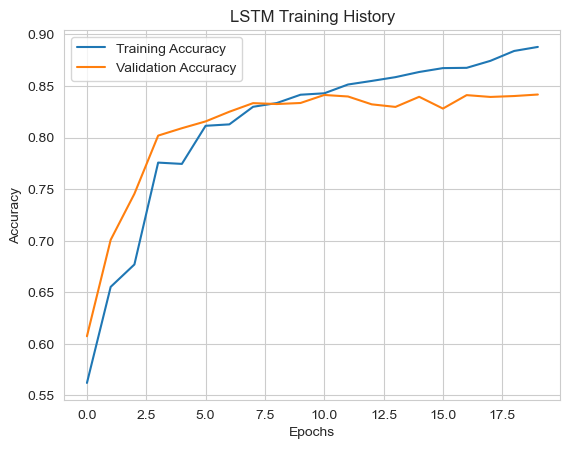

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [153]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training History')
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Predict

In [24]:
updated_df = pd.read_pickle("updated_df.pkl")

In [25]:
scaler = StandardScaler()
updated_df[time_series_features] = scaler.fit_transform(updated_df[time_series_features])

In [26]:
X_unlabelled_sequences = []
for _, group in updated_df.groupby('new_segment'):
    X_unlabelled_sequences.append(group[time_series_features].values)  # Raw sequences

In [27]:
for i, seq in enumerate(X_unlabelled_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (47, 3)
Shape of sequence 1: (144, 3)
Shape of sequence 2: (142, 3)
Shape of sequence 3: (49, 3)
Shape of sequence 4: (167, 3)
Shape of sequence 5: (24, 3)
Shape of sequence 6: (97, 3)
Shape of sequence 7: (94, 3)
Shape of sequence 8: (194, 3)
Shape of sequence 9: (194, 3)
Shape of sequence 10: (132, 3)
Shape of sequence 11: (59, 3)
Shape of sequence 12: (82, 3)
Shape of sequence 13: (109, 3)
Shape of sequence 14: (57, 3)
Shape of sequence 15: (134, 3)
Shape of sequence 16: (194, 3)
Shape of sequence 17: (82, 3)
Shape of sequence 18: (22, 3)
Shape of sequence 19: (84, 3)
Shape of sequence 20: (7, 3)
Shape of sequence 21: (127, 3)
Shape of sequence 22: (42, 3)
Shape of sequence 23: (19, 3)
Shape of sequence 24: (37, 3)
Shape of sequence 25: (22, 3)
Shape of sequence 26: (47, 3)
Shape of sequence 27: (7, 3)
Shape of sequence 28: (69, 3)
Shape of sequence 29: (47, 3)
Shape of sequence 30: (32, 3)
Shape of sequence 31: (62, 3)
Shape of sequence 32: (32, 3)
Shape of seq

In [28]:
updated_df['new_segment'].nunique()

98975

Do rolling window function but only to apply padding

In [29]:
import numpy as np

def create_rolling_windows_unlabelled(X_sequences, window_size=100, step=50):
    """
    Creates rolling window segments from time-series data, padding short sequences at the beginning.

    Parameters:
    - X_sequences: List of time-series feature sequences (NumPy arrays)
    - window_size: Number of time steps per window
    - step: Step size between windows (e.g., 10 for overlap)

    Returns:
    - X_windows: NumPy array of rolling window samples
    """
    X_windows = []

    for seq in X_sequences:  # Loop through sequences
        # If sequence is shorter than window_size, pad at the beginning
        if len(seq) < window_size:
            pad_length = window_size - len(seq)
            pad = np.zeros((pad_length, seq.shape[1]))  # Create zero padding
            seq = np.vstack((pad, seq))  # Stack padding **before** existing data

            # Add the single padded sequence
            X_windows.append(seq)
            continue  # Skip rolling window logic for this sequence

        # Create rolling windows within the sequence
        for j in range(0, len(seq) - window_size + 1, step):
            X_windows.append(seq[j:j + window_size])  # Extract window

    return np.array(X_windows)

# **Apply rolling windows to unlabeled data**
window_size = 200
step_size = 200

X_unlabelled_windows = create_rolling_windows_unlabelled(X_unlabelled_sequences, window_size, step_size)
print("Shape of X_train:", X_unlabelled_windows.shape)



Shape of X_train: (98975, 200, 3)


In [30]:
# Make predictions
unlabelled__pred = model.predict(X_unlabelled_windows)

3093/3093 ━━━━━━━━━━━━━━━━━━━━ 159s 51ms/step


In [31]:
y_pred_classes = np.argmax(unlabelled__pred, axis=1)

In [32]:
print(y_pred_classes[:50])

[4 4 4 4 4 0 4 4 2 4 4 4 4 4 1 4 2 4 4 4 1 4 0 4 1 1 1 2 3 3 3 3 3 2 3 3 2
 3 3 3 1 3 3 3 3 1 3 1 3 0]


Convert predictions to labels (by 'new_segment')

Add predicted labels to the unlabelled dataset!

In [33]:

# Step 1: Create a mapping of unique segments to labels
unique_segments = updated_df['new_segment'].unique()
# Assume labels_array_unique has length = len(unique_segments)
segment_to_label = dict(zip(unique_segments, y_pred_classes))

# Step 2: Map labels back to all rows
updated_df['predicted_label'] = updated_df['new_segment'].map(segment_to_label)


In [34]:
# Select the first 500 rows
first_1500_rows = updated_df.head(5000)

# Save the first 500 rows to a CSV file
first_1500_rows.to_csv("first_1500_rows.csv", index=False)

# Display a confirmation message
print("First 500 rows saved to 'first_500_rows.csv'")

First 500 rows saved to 'first_500_rows.csv'


In [35]:
updated_df['label'] = updated_df['predicted_label']


In [36]:
df

lat         lon          alt  elapsed time                time  \
137  39.948120  116.303378     0.000000  39535.367118 2008-03-28 08:48:39   
138  39.948110  116.303418     0.000000  39535.367153 2008-03-28 08:48:42   
139  39.947997  116.303410     0.000000  39535.367222 2008-03-28 08:48:48   
140  39.947952  116.303377     0.000000  39535.367280 2008-03-28 08:48:53   
141  39.947902  116.303405     0.000000  39535.367338 2008-03-28 08:48:58   
..         ...         ...          ...           ...                 ...   
55   39.984650  116.182117  1158.136483  39374.292743 2007-10-19 07:01:33   
634  39.892085  116.328959   149.924311  40608.471354 2011-03-06 11:18:45   
635  39.892074  116.328959   149.293596  40608.471412 2011-03-06 11:18:50   
636  39.892064  116.328959   149.058396  40608.471470 2011-03-06 11:18:55   
637  39.892055  116.328960   148.956555  40608.471528 2011-03-06 11:19:00   

             trajectory  label  user  segment  distance     speed  time_diff  \
137  20080328075913.plt      1   104        1  0.011674 -0.574159        6.0   
138  20080328075913.plt      1   104        1  0.003590 -0.649555        3.0   
139  20080328075913.plt      1   104        1  0.012619 -0.558307        6.0   
140  20080328075913.plt      1   104        1  0.005753 -0.654194        5.0   
141  20080328075913.plt      1   104        1  0.006064 -0.647931        5.0   
..                  ...    ...   ...      ...       ...       ...        ...   
55   20071019052429.plt      4   114    10073  0.050993 -0.741966      183.0   
634  20110306101335.plt      4   147    10074  0.002690 -0.715851        5.0   
635  20110306101335.plt      4   147    10074  0.001223 -0.745391        5.0   
636  20110306101335.plt      4   147    10074  0.001112 -0.747630        5.0   
637  20110306101335.plt      4   147    10074  0.001004 -0.749795        5.0   

     acceleration     bearing  heading_change     Vrate  angular_velocity  \
137     -0.025356  162.271799       12.694739  0.104603          2.115790   
138     -0.153923  108.230072       54.041727  0.625892        -18.013909   
139      0.084890  183.253040       75.022968  0.431006         12.503828   
140     -0.118672  209.566451       26.313411  0.827881          5.262682   
141      0.002274  156.469520       53.096931  0.051301        -10.619386   
..            ...         ...             ...       ...               ...   
55      -0.005443  204.689674       49.552053  0.332744         -0.270776   
634      0.026720  187.287185      120.738584  0.496805        -24.147717   
635     -0.040117  180.000000        7.287185  1.199585         -1.457437   
636     -0.007792  180.000000        0.000000  0.100000          0.000000   
637     -0.007706  175.127290        4.872710  0.107095         -0.974542   

     angular_acceleration  
137              0.017800  
138             -0.113979  
139              0.069920  
140             -0.031951  
141             -0.058893  
..                    ...  
55              -0.009406  
634             -0.564867  
635              0.061373  
636             -0.004830  
637             -0.012412  

[4560433 rows x 18 columns]

Merge the predicted unlabelled dataset and the original dataset!

In [37]:
common_columns = ['label', 'segment', 'speed', 'acceleration', 'angular_acceleration']

# Merge the DataFrames on the specified common columns
merged_df = pd.concat([df[common_columns], updated_df[common_columns]])

In [69]:
merged_df

label  segment     speed  acceleration  angular_acceleration
137         1        1 -0.574159     -0.025356              0.017800
138         1        1 -0.649555     -0.153923             -0.113979
139         1        1 -0.558307      0.084890              0.069920
140         1        1 -0.654194     -0.118672             -0.031951
141         1        1 -0.647931      0.002274             -0.058893
...       ...      ...       ...           ...                   ...
512806      4  999.0.0 -0.781126     -0.049108             -0.016324
512807      4  999.0.0 -0.781758     -0.007486             -0.006495
512808      4  999.0.0 -0.809356     -0.030676             -0.013236
512809      4  999.0.0 -0.791008      0.008835              0.011639
512810      4  999.0.0 -0.759916      0.019794              0.019953

[8997776 rows x 5 columns]

In [38]:
print(updated_df['segment'].nunique())
print(df['segment'].nunique())
print(merged_df['segment'].nunique())

27050
9844
36894


merged sequences

In [39]:
X_sequences_merged = []
y_sequences_merged = []

for _, group in merged_df.groupby('segment'):
    X_sequences_merged.append(group[time_series_features].values)  # Raw sequences
    y_sequences_merged.append(group['label'].iloc[0])  # Assign one label per segment

In [40]:
for i, seq in enumerate(X_sequences_merged):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (130, 3)
Shape of sequence 1: (183, 3)
Shape of sequence 2: (32, 3)
Shape of sequence 3: (3, 3)
Shape of sequence 4: (21, 3)
Shape of sequence 5: (32, 3)
Shape of sequence 6: (22, 3)
Shape of sequence 7: (37, 3)
Shape of sequence 8: (62, 3)
Shape of sequence 9: (13, 3)
Shape of sequence 10: (8, 3)
Shape of sequence 11: (6, 3)
Shape of sequence 12: (63, 3)
Shape of sequence 13: (9, 3)
Shape of sequence 14: (1, 3)
Shape of sequence 15: (20, 3)
Shape of sequence 16: (25, 3)
Shape of sequence 17: (19, 3)
Shape of sequence 18: (8, 3)
Shape of sequence 19: (53, 3)
Shape of sequence 20: (1, 3)
Shape of sequence 21: (21, 3)
Shape of sequence 22: (4, 3)
Shape of sequence 23: (29, 3)
Shape of sequence 24: (59, 3)
Shape of sequence 25: (12, 3)
Shape of sequence 26: (21, 3)
Shape of sequence 27: (172, 3)
Shape of sequence 28: (6, 3)
Shape of sequence 29: (74, 3)
Shape of sequence 30: (123, 3)
Shape of sequence 31: (97, 3)
Shape of sequence 32: (845, 3)
Shape of sequence 33: (1

convert y

In [41]:
# Convert labels to one-hot encoding
y_sequences_merged = to_categorical(y_sequences_merged)
#X_sequences.shape()
y_sequences_merged

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

Create new validation set! for the test set, use the one from earlier!

In [42]:
X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(X_sequences_merged, y_sequences_merged, test_size=0.1, random_state=19)

Rolling window! (just padding here), nochmal rolling window überlegen!

In [43]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 200  # Step between windows

# Create rolling windows
X_train_merged, y_train_merged = create_rolling_windows(X_train_merged, y_train_merged, window_size, step_size)

# Verify shape
print("Shape of X_train_merged:", X_train_merged.shape)
print("Shape of y_train_merged:", y_train_merged.shape)

Shape of X_train_merged: (44855, 200, 3)
Shape of y_train_merged: (44855, 5)


In [44]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 200  # Step between windows

# Create rolling windows
X_val_merged, y_val_merged = create_rolling_windows(X_val_merged, y_val_merged, window_size, step_size)

# Verify shape
print("Shape of X_val_merged:", X_val_merged.shape)
print("Shape of y_val_merged:", y_val_merged.shape)

Shape of X_val_merged: (5333, 200, 3)
Shape of y_val_merged: (5333, 5)


In [45]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history_merged = model.fit(X_train_merged, y_train_merged, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val_merged, y_val_merged), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 209s 149ms/step - accuracy: 0.7275 - loss: 0.7897 - val_accuracy: 0.7866 - val_loss: 0.6231 - learning_rate: 5.0000e-04
Epoch 2/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 196s 140ms/step - accuracy: 0.7632 - loss: 0.6634 - val_accuracy: 0.7911 - val_loss: 0.5962 - learning_rate: 5.0000e-04
Epoch 3/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 195s 139ms/step - accuracy: 0.7759 - loss: 0.6358 - val_accuracy: 0.8014 - val_loss: 0.5789 - learning_rate: 5.0000e-04
Epoch 4/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 196s 139ms/step - accuracy: 0.7804 - loss: 0.6242 - val_accuracy: 0.8048 - val_loss: 0.5681 - learning_rate: 5.0000e-04
Epoch 5/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 204s 145ms/step - accuracy: 0.7916 - loss: 0.5948 - val_accuracy: 0.8061 - val_loss: 0.5555 - learning_rate: 5.0000e-04
Epoch 6/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 200s 143ms/step - accuracy: 0.7943 - loss: 0.5872 - val_accuracy: 0.8146 - val_loss: 0.5405 - learning_rate: 5.0000e-04
Epoch 7/50
1402/1402 ━━━━━━━

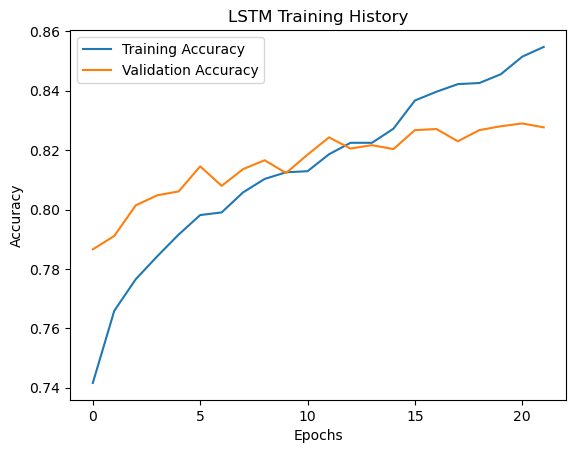

454/454 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.89      2005
           1       0.86      0.75      0.80      3193
           2       0.79      0.82      0.80      1789
           3       0.95      0.96      0.96      3875
           4       0.82      0.93      0.87      3646

    accuracy                           0.87     14508
   macro avg       0.87      0.86      0.86     14508
weighted avg       0.88      0.87      0.87     14508



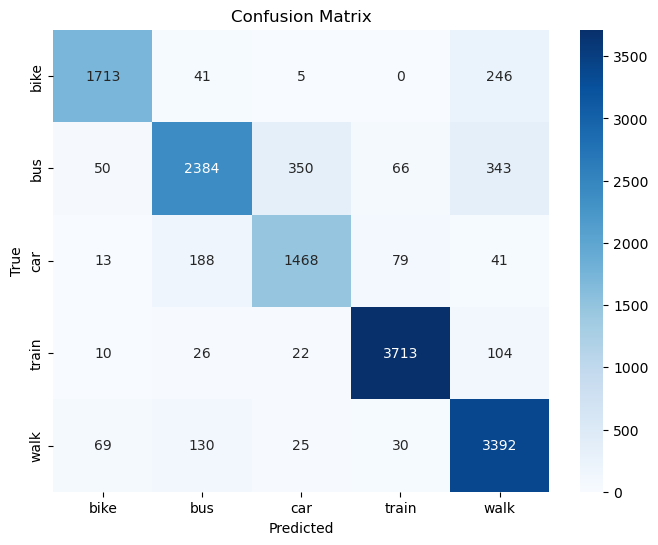

In [46]:
# Plot training history
plt.plot(history_merged.history['accuracy'], label='Training Accuracy')
plt.plot(history_merged.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training History')
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Mit Rolling Window

In [47]:
X_train_merged2, X_val_merged2, y_train_merged2, y_val_merged2 = train_test_split(X_sequences_merged, y_sequences_merged, test_size=0.1, random_state=19)

In [48]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 50  # Step between windows

# Create rolling windows
X_train_merged2, y_train_merged2 = create_rolling_windows(X_train_merged2, y_train_merged2, window_size, step_size)

# Verify shape
print("Shape of X_train_merged:", X_train_merged2.shape)
print("Shape of y_train_merged:", y_train_merged2.shape)

Shape of X_train_merged: (86275, 200, 3)
Shape of y_train_merged: (86275, 5)


In [49]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 50  # Step between windows

# Create rolling windows
X_val_merged2, y_val_merged2 = create_rolling_windows(X_val_merged2, y_val_merged2, window_size, step_size)

# Verify shape
print("Shape of X_val_merged:", X_val_merged2.shape)
print("Shape of y_val_merged:", y_val_merged2.shape)

Shape of X_val_merged: (11075, 200, 3)
Shape of y_val_merged: (11075, 5)


init again

In [50]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 198, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 198, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 198, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,565 (541.27 KB)

 Trainable params: 138,565 (541.27 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=4,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history_merged2 = model.fit(X_train_merged2, y_train_merged2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val_merged2, y_val_merged2), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 430s 159ms/step - accuracy: 0.5006 - loss: 1.2242 - val_accuracy: 0.5992 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 2/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 396s 147ms/step - accuracy: 0.6504 - loss: 0.9498 - val_accuracy: 0.7549 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 3/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 388s 144ms/step - accuracy: 0.7253 - loss: 0.7752 - val_accuracy: 0.7767 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 4/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 380s 141ms/step - accuracy: 0.7519 - loss: 0.7114 - val_accuracy: 0.8061 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 5/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 419s 155ms/step - accuracy: 0.7775 - loss: 0.6591 - val_accuracy: 0.8224 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 6/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 412s 153ms/step - accuracy: 0.7868 - loss: 0.6302 - val_accuracy: 0.8202 - val_loss: 0.5433 - learning_rate: 0.0010
Epoch 7/50
2697/2697 ━━━━━━━━━━━━━━━━━━━━ 397s 147ms

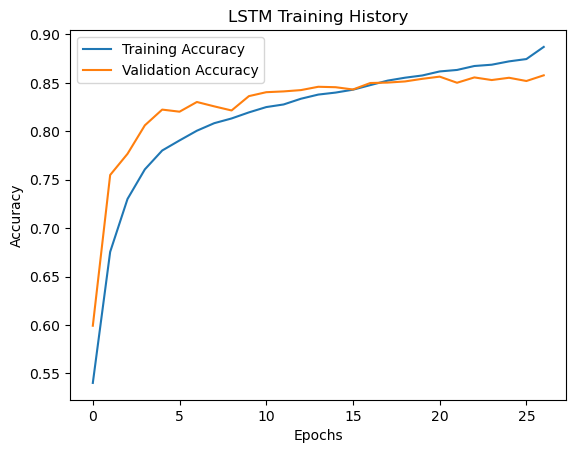

454/454 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      2005
           1       0.89      0.81      0.85      3193
           2       0.87      0.86      0.86      1789
           3       0.96      0.96      0.96      3875
           4       0.84      0.92      0.88      3646

    accuracy                           0.89     14508
   macro avg       0.89      0.89      0.89     14508
weighted avg       0.90      0.89      0.89     14508



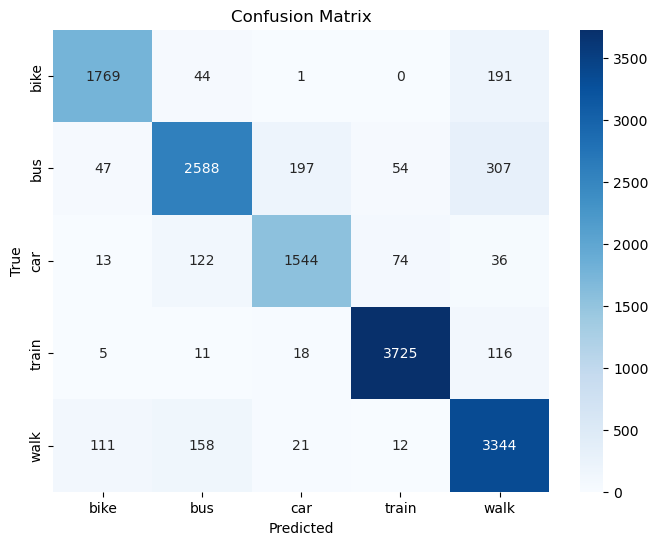

In [52]:
# Plot training history
plt.plot(history_merged2.history['accuracy'], label='Training Accuracy')
plt.plot(history_merged2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Training History')
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Normalized Results

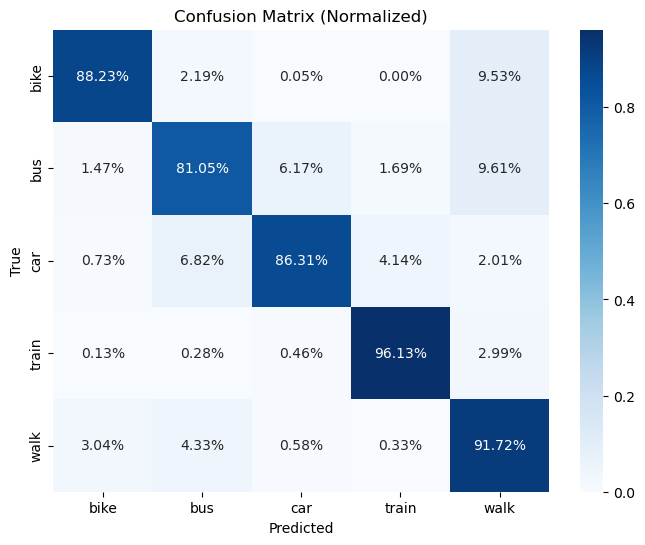

In [53]:
# Assuming y_true_classes and y_pred_classes are already defined
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [75]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="lstm_model_architecture.png", show_shapes=True, show_layer_names=True, dpi=300)

You must install pydot (`pip install pydot`) for `plot_model` to work.


SECA

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(128 * 4, latent_dim)  # Adjust based on input sequence length
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4)
        x = self.decoder(x)
        return x

class Classifier(nn.Module):
    def __init__(self, latent_dim=128, num_classes=6):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)

class SemiSupervisedCAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=6):
        super(SemiSupervisedCAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.classifier = Classifier(latent_dim, num_classes)
    
    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        class_pred = self.classifier(z)
        return recon_x, class_pred

# Custom dataset class for GPS data
class GPSDataset(data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)  # (batch, channels, seq_len)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Preprocessing function for GPS data
def preprocess_gps_data(df, seq_length=50):
    scaler = MinMaxScaler()
    df[['lat', 'lon', 'speed']] = scaler.fit_transform(df[['lat', 'lon', 'speed']])
    
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        sequences.append(df[['lat', 'lon', 'speed']].iloc[i:i+seq_length].values)
        labels.append(df['label'].iloc[i + seq_length])
    
    return np.array(sequences), np.array(labels)

# Dataloader function
def get_dataloader(df, batch_size=32, seq_length=50, shuffle=True):
    sequences, labels = preprocess_gps_data(df, seq_length)
    dataset = GPSDataset(sequences, labels)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Training and validation loop with early stopping and learning rate scheduling
def train_and_validate(model, train_loader, val_loader, optimizer, criterion_recon, criterion_class, device, alpha=0.5, epochs=10, patience=3):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss, recon_loss, class_loss = 0, 0, 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            recon_sequences, class_pred = model(sequences)
            
            loss_recon = criterion_recon(recon_sequences, sequences)
            loss_class = criterion_class(class_pred, labels)
            loss = alpha * loss_recon + (1 - alpha) * loss_class
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            recon_loss += loss_recon.item()
            class_loss += loss_class.item()
        
        model.eval()
        val_loss, val_recon_loss, val_class_loss = 0, 0, 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                recon_sequences, class_pred = model(sequences)
                
                loss_recon = criterion_recon(recon_sequences, sequences)
                loss_class = criterion_class(class_pred, labels)
                loss = alpha * loss_recon + (1 - alpha) * loss_class
                
                val_loss += loss.item()
                val_recon_loss += loss_recon.item()
                val_class_loss += loss_class.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss / len(train_loader):.4f} (Recon: {recon_loss / len(train_loader):.4f}, Class: {class_loss / len(train_loader):.4f}) - Val Loss: {val_loss:.4f} (Recon: {val_recon_loss / len(val_loader):.4f}, Class: {val_class_loss / len(val_loader):.4f})")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break


In [100]:
y_sequences_merged

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [101]:
updated_df

lat         lon    alt  elapsed time                time  \
6       39.974530  116.399758  489.0  39816.056956 2009-01-03 01:22:01   
7       39.974577  116.399745  490.0  39816.056991 2009-01-03 01:22:04   
8       39.974623  116.399731  491.0  39816.057025 2009-01-03 01:22:07   
9       39.974666  116.399713  491.0  39816.057060 2009-01-03 01:22:10   
10      39.974700  116.399755  491.0  39816.057095 2009-01-03 01:22:13   
...           ...         ...    ...           ...                 ...   
512806  39.975701  116.331272  150.0  39833.222049 2009-01-20 05:19:45   
512807  39.975699  116.331199  154.0  39833.222106 2009-01-20 05:19:50   
512808  39.975677  116.331150  159.0  39833.222164 2009-01-20 05:19:55   
512809  39.975643  116.331099  164.0  39833.222222 2009-01-20 05:20:00   
512810  39.975619  116.331019  169.0  39833.222280 2009-01-20 05:20:05   

                trajectory  label  user  segment  distance  ...  time_diff  \
6       20090103012134.plt      4   135    1.0.0  0.004870  ...        5.0   
7       20090103012134.plt      4   135    1.0.0  0.005342  ...        3.0   
8       20090103012134.plt      4   135    1.0.0  0.005252  ...        3.0   
9       20090103012134.plt      4   135    1.0.0  0.005021  ...        3.0   
10      20090103012134.plt      4   135    1.0.0  0.005206  ...        3.0   
...                    ...    ...   ...      ...       ...  ...        ...   
512806  20090120010934.plt      4   158  999.0.0  0.006256  ...        5.0   
512807  20090120010934.plt      4   158  999.0.0  0.006224  ...        5.0   
512808  20090120010934.plt      4   158  999.0.0  0.004839  ...        5.0   
512809  20090120010934.plt      4   158  999.0.0  0.005760  ...        5.0   
512810  20090120010934.plt      4   158  999.0.0  0.007321  ...        5.0   

        acceleration     bearing  heading_change     Vrate  angular_velocity  \
6          -0.001836   27.061885        9.554462  0.061215         -1.910892   
7           0.108250  348.032515      320.970630  0.453068        106.990210   
8          -0.011228  346.871561        1.160954  0.017141         -0.386985   
9          -0.017931  342.214346        4.657215  0.045977         -1.552405   
10          0.001840   43.429855      298.784491  0.035450        -99.594830   
...              ...         ...             ...       ...               ...   
512806     -0.049108  276.121913        1.732387  0.393379          0.346477   
512807     -0.007486  267.952465        8.169448  0.005093         -1.633890   
512808     -0.030676  239.634291       28.318174  0.286241         -5.663635   
512809      0.008835  228.978003       10.656288  0.159878         -2.131258   
512810      0.019794  248.620552       19.642549  0.213168          3.928510   

        angular_acceleration   index  new_segment  predicted_label  
6                   0.180188       7            1                4  
7                   0.597055       8            1                4  
8                  -0.588661       9            1                4  
9                  -0.006370      10            1                4  
10                 -0.537485      11            1                4  
...                      ...     ...          ...              ...  
512806             -0.016324  512807        99100                4  
512807             -0.006495  512808        99100                4  
512808             -0.013236  512809        99100                4  
512809              0.011639  512810        99100                4  
512810              0.019953  512811        99100                4  

[4437343 rows x 21 columns]

In [105]:
X_val

array([[[-6.69110635e-01, -4.23358340e-03, -9.16628892e-03],
        [-6.65763807e-01, -4.93298394e-03, -9.63108833e-03],
        [-6.57936771e-01, -4.21481906e-03, -9.37244427e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-4.45924627e-01, -1.62228803e-01, -5.59643719e-02],
        [-6.56774833e-01, -6.29261700e-01,  5.22698234e-01],
        [-7.08680423e-01, -1.58782966e-01, -8.24441184e-02],
        ...,
        [-5.42671422e-01, -6.74861991e-01, -1.17840841e-02],
        [-3.55862010e-01,  5.47817455e-01, -1.22472186e+00],
        [ 7.93366422e-01,  3.39659394e+00,  1.30381716e+00]],

       [[-3.74880460e-01, -1.57559707e-01,  2.10217195e-02],
        [-5.00520620e-01, -3.77038533e-01, -1.38384522e+00],
        [-5.11997747e-01, -3.91140349e-02,  2.71714006e+00],
        ...,
        [-6.06301568e-01, -2.66997636e-01,

In [117]:
import pandas as pd


# Ensure required columns exist
assert all(col in df.columns for col in ["lat", "lon", "speed", "label"]), "Missing required columns!"


In [119]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets (80-20 split)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create dataloaders
train_loader = get_dataloader(train_df, batch_size=32, seq_length=50, shuffle=True)
val_loader = get_dataloader(val_df, batch_size=32, seq_length=50, shuffle=False)


: 

In [ ]:
train_loader

In [ ]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = SemiSupervisedCAE(latent_dim=128, num_classes=6).to(device)

# Define loss functions
criterion_recon = nn.MSELoss()  # Reconstruction loss
criterion_class = nn.CrossEntropyLoss()  # Classification loss

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
train_and_validate(
    model=model, 
    train_loader=X_train, 
    val_loader=X_val, 
    optimizer=optim.Adam(model.parameters(), lr=0.001), 
    criterion_recon=nn.MSELoss(), 
    criterion_class=nn.CrossEntropyLoss(), 
    device=device, 
    alpha=0.5, 
    epochs=20, 
    patience=5
)

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


ValueError: too many values to unpack (expected 2)